# Pet Finder - Adopción de Mascotas

PetFinder.es una plataforma de adopción de Mascotas de Malasia, con una base de datos de más de 150.000 animales. 

Las tasas de adopción de animales están fuertemente correlacionadas con los metadatos asociados con sus perfiles en línea, como el texto descriptivo y las características de las fotografías. Como ejemplo, PetFinder está experimentando actualmente con una herramienta de inteligencia artificial simple llamada Cuteness Meter, que clasifica qué tan linda es una mascota en función de las cualidades presentes en sus fotos.

En esta competencia, desarrollará algoritmos para predecir la adoptabilidad de las mascotas, específicamente, ¿qué tan rápido se adopta una mascota?

Web Organización: https://www.petfinder.my/

Datos: https://www.kaggle.com/c/petfinder-adoption-prediction

## Script Inicial - Análisis Exploratorio

En este trabajo se busca predecir la velocidad a la que se adopta una mascota, según la lista de la mascota en PetFinder. 

A veces, un perfil representa a un grupo de mascotas. En este caso, la velocidad de adopción está determinada por la velocidad a la que se adoptan todas las mascotas. 

Los datos incluyen datos de **Texto Libre**, **Datos Tabulares** e **Emágenes**, lo que lo hace un dataset sumamente rico para explorar

## Librerias y Funciones Definidas

In [6]:
import os
os.chdir(
    os.path.join(
        os.getcwd(), '../../../work/')
    )
print("Directorio actual:", os.getcwd())

# Carga de Librerias
# Generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de palabras
from wordcloud import WordCloud, STOPWORDS

# Scipy
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import kruskal

# Statsmodels
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf

# Pingouin
import pingouin as pg

Directorio actual: c:\Users\adria\Documents\Adrián\AUSTRAL\2025 - 1er Bimestre - Laboratorio de Implementación II\TPs\Repo_Grupo_9\UA_MDM_Labo2_G9\work


In [7]:
# Paths para acceso archivos
#Este notebook asume la siguiente estructura de carpetas a partir de la ubicacion de base_dir 
#(dos niveles arriba de la cƒarpeta donde se ejecuta el notebook). 
# /ƒ/ƒ
# /UA_MDM_Labo2/inputƒ
# /UA_MDM_Labo2/input/petfinder-adoption-prediction/            <- Aca deben ir todos los archivos de datos de la competencia 
# /UA_MDM_Labo2/tutoriales/                       <- Aca deben poner los notebooks y scripts que les compartimos
# /UA_MDM_Labo2/work/                             <- Resultados de notebooks iran dentro de esta carpeta en subcarpetas
# /UA_MDM_Labo2/work/models/                     <- Modelos entrenados en archivos joblibs
# /UA_MDM_Labo2/work/optuna_temp_artifacts/      <- Archivos que queremos dejar como artefacto de un trial de optuna (optuna los copiara a la carpeta de abajo)
# /UA_MDM_Labo2/work/optuna_artifacts/           <- Archivos con artefactos que sibimos a optuna

#Subimos dos niveles para quedar en la carpeta que contiene input y UA_MDM_Labo2
BASE_DIR = '../'

#Datos de entrenamiento 
PATH_TO_TRAIN = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/")

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")


SEED = 42 #Semilla de procesos aleatorios (para poder replicar exactamente al volver a correr un modelo)
TEST_SIZE = 0.2 #Facción para train/test= split

In [8]:
# Cargar los datos
df = pd.read_csv(os.path.join(PATH_TO_TRAIN, "train.csv"))
df_breed_labels = pd.read_csv(os.path.join(PATH_TO_TRAIN, '../breed_labels.csv'))
df_color_labels = pd.read_csv(os.path.join(PATH_TO_TRAIN, '../color_labels.csv'))
df_state_labels = pd.read_csv(os.path.join(PATH_TO_TRAIN, '../state_labels.csv'))

df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


## Funciones predefinidas

In [9]:
# Función para mostrar todos los gráficos de distribución para una variable
def graficos_distribucion(df, variable):
    plt.figure(figsize=(15, 4))

    # Histograma + KDE
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], kde=True)
    plt.title(f"Histograma de {variable}")
    plt.xlabel(variable)
    plt.ylabel("Frecuencia")

    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(y=df[variable])
    plt.title(f"Boxplot de {variable}")
    plt.xlabel(variable)

    # QQ Plot
    plt.subplot(1, 3, 3)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f"QQ Plot de {variable}")

    plt.tight_layout()
    plt.show()

In [10]:
# Función para aplicar distintos tests de normalidad y graficar
def analizar_normalidad(df, variable):
    print(f"\n--- Normalidad para {variable} ---")

    # Shapiro-Wilk Test
    stat, p = shapiro(df[variable])
    print(f"Shapiro-Wilk: W={stat:.4f}, p={p:.4f} {'-> No normal' if p < 0.05 else '-> Normal'}")
    
    # D'Agostino and Pearson's test
    stat, p = normaltest(df[variable])
    print(f"D’Agostino-Pearson: stat={stat:.4f}, p={p:.4f} {'-> No normal' if p < 0.05 else '-> Normal'}")

    # Anderson-Darling Test
    result = anderson(df[variable])
    print(f"Anderson-Darling: A={result.statistic:.4f}")
    for i in range(len(result.critical_values)):
        sig = result.significance_level[i]
        crit = result.critical_values[i]
        print(f"  Nivel {sig}%: crítico={crit:.4f} {'-> No normal' if result.statistic > crit else '-> Normal'}")


## ETAPA 1: INFORMACIÓN GENERAL

### Data Fields

* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

In [11]:
print("Información general del dataset:")
print(df.info())

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14

In [12]:
# Valores nulos por columna
print("Valores nulos por columna:")
print(df.isnull().sum())

# Registros duplicados
print("Número de registros duplicados:", df.duplicated().sum())

# Ejemplo de filas de Name null
print(df[df['Name'].isnull()].head())

# Miro si hay una fila entera de nulls
#df[df.isnull().all(axis=1)]


Valores nulos por columna:
Type                0
Name             1265
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64
Número de registros duplicados: 0
    Type Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
5      2  NaN    3     266       0       2       5       6       0   
8      2  NaN    2     265       0       2       6       0       0   
19     2  NaN    1     266       0       3       1       2       7   
33     2  NaN    4     266       0       2       1       6       7   
36     2  NaN   24     265     292       2      

## ETAPA 2: Análisis Univariado

### Target: AdoptionSpeed

The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [13]:
# Valores nulos
df.AdoptionSpeed.isna().sum()

0

In [14]:
# Valores únicos
df.AdoptionSpeed.value_counts().sort_index()

AdoptionSpeed
0     410
1    3090
2    4037
3    3259
4    4197
Name: count, dtype: int64

In [15]:
# Proporción de Valores únicos
df.AdoptionSpeed.value_counts(normalize=True).round(2).sort_index()

AdoptionSpeed
0    0.03
1    0.21
2    0.27
3    0.22
4    0.28
Name: proportion, dtype: float64

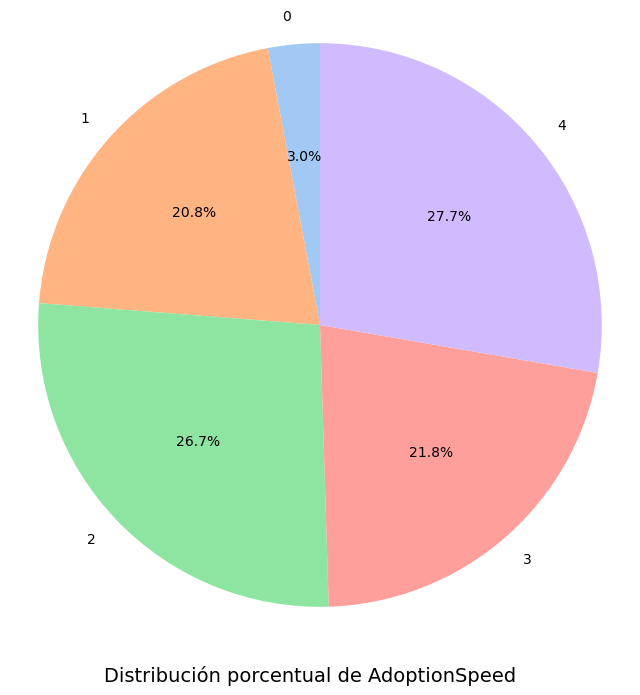

In [16]:
# Datos
adoption_counts = df['AdoptionSpeed'].value_counts(normalize=True).sort_index().round(2)
colors = sns.color_palette('pastel')[0:5]

# Crear figura y gráfico
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(adoption_counts, labels=adoption_counts.index,
       autopct='%1.1f%%', colors=colors, startangle=90)
ax.axis('equal')  # Círculo perfecto

# Título abajo
fig.text(0.5, 0.05, 'Distribución porcentual de AdoptionSpeed', ha='center', fontsize=14)
plt.show()

#### Consideraciones
- Sólo un 3% tiene una dopción rápida
- Aproximadamente un 60% de loc casos con adoptados dentro del mes de ingresados a la lista de adopción
- Hay casi un 28% de casos que no llegaron a ser adoptados luego de haver estado 100 dias en la lista de adopción

### `Type`

In [17]:
# Valores nulos
df.Type.isna().sum()

0

In [18]:
# Valores únicos
df.Type.value_counts().sort_index()

Type
1    8132
2    6861
Name: count, dtype: int64

In [19]:
# Creamos una columna descriptiva de 'Type'
Type_map = {1: 'perro', 2: 'gato'}

df['Type_df'] = df['Type'].map(Type_map)

In [20]:
# Valores únicos con etiquetas
df.Type_df.value_counts().sort_values(ascending=False)

Type_df
perro    8132
gato     6861
Name: count, dtype: int64

In [21]:
# Proporción de Valores únicos
df.Type_df.value_counts(normalize=True).round(2).sort_values(ascending=False)

Type_df
perro    0.54
gato     0.46
Name: proportion, dtype: float64

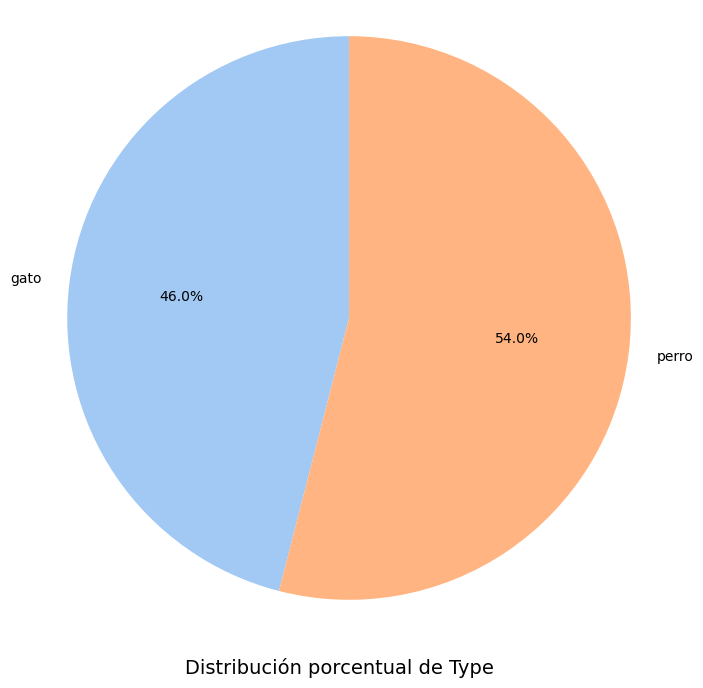

In [22]:
type_counts = df['Type_df'].value_counts(normalize=True).sort_index().round(2)
colors = sns.color_palette('pastel')[0:2]

# Crear figura y gráfico
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(type_counts, labels=type_counts.index,
       autopct='%1.1f%%', colors=colors, startangle=90)
ax.axis('equal')  # Círculo perfecto

# Título abajo
fig.text(0.5, 0.05, 'Distribución porcentual de Type', ha='center', fontsize=14)
plt.show()

#### Consideraciones de `Type`
- No hay valores nulos
- Hay 54% de Perros y 46% de Gatos



### Age

In [23]:
# Valores de tendencia central y dispersión
df.Age.describe()

count    14993.000000
mean        10.452078
std         18.155790
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max        255.000000
Name: Age, dtype: float64

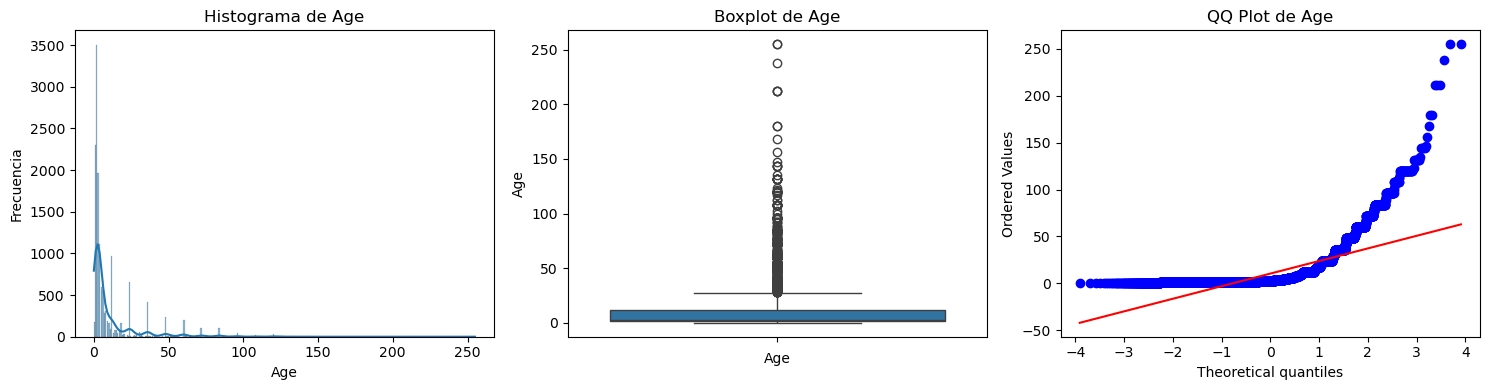

In [24]:
# Gráficos de distribución
graficos_distribucion(df, 'Age')

In [25]:
# Test de normalidad    
analizar_normalidad(df, 'Age')


--- Normalidad para Age ---
Shapiro-Wilk: W=0.5466, p=0.0000 -> No normal
D’Agostino-Pearson: stat=12029.5416, p=0.0000 -> No normal
Anderson-Darling: A=2304.0481
  Nivel 15.0%: crítico=0.5760 -> No normal
  Nivel 10.0%: crítico=0.6560 -> No normal
  Nivel 5.0%: crítico=0.7870 -> No normal
  Nivel 2.5%: crítico=0.9180 -> No normal
  Nivel 1.0%: crítico=1.0920 -> No normal


c:\Users\adria\anaconda3\envs\ldi2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14993.
  res = hypotest_fun_out(*samples, **kwds)


In [26]:
# Valores nulos
df.Age.isna().sum()   

0

In [27]:
# Valores negativos
df['Age'][df['Age']<0].count()

0

El campo `Age` muestra una distribución no normal, sin valores nulos o negativos.

### Breed1
Se agregan dos campos `BreedName1 y BreedName2` que corresponde a las etiquetas de BreedName del archivo `breed_labels.csv`. A lo mejor pueden servir tener las etiquetas.


In [163]:
# Crear un diccionario de mapeo de BreedID a BreedName
breed_dict = df_breed_labels.set_index('BreedID')['BreedName'].to_dict()

print(breed_dict)

# Agregar una nueva columna 'BreedName' en df_train mapeando 'Breed1'
df['BreedName1'] = df['Breed1'].map(breed_dict)

# Mostrar las primeras filas para verificar
df.head()

{1: 'Affenpinscher', 2: 'Afghan Hound', 3: 'Airedale Terrier', 4: 'Akbash', 5: 'Akita', 6: 'Alaskan Malamute', 7: 'American Bulldog', 8: 'American Eskimo Dog', 9: 'American Hairless Terrier', 10: 'American Staffordshire Terrier', 11: 'American Water Spaniel', 12: 'Anatolian Shepherd', 13: 'Appenzell Mountain Dog', 14: 'Australian Cattle Dog/Blue Heeler', 15: 'Australian Kelpie', 16: 'Australian Shepherd', 17: 'Australian Terrier', 18: 'Basenji', 19: 'Basset Hound', 20: 'Beagle', 21: 'Bearded Collie', 22: 'Beauceron', 23: 'Bedlington Terrier', 24: 'Belgian Shepherd Dog Sheepdog', 25: 'Belgian Shepherd Laekenois', 26: 'Belgian Shepherd Malinois', 27: 'Belgian Shepherd Tervuren', 28: 'Bernese Mountain Dog', 29: 'Bichon Frise', 30: 'Black and Tan Coonhound', 31: 'Black Labrador Retriever', 32: 'Black Mouth Cur', 33: 'Black Russian Terrier', 34: 'Bloodhound', 35: 'Blue Lacy', 36: 'Bluetick Coonhound', 37: 'Boerboel', 38: 'Bolognese', 39: 'Border Collie', 40: 'Border Terrier', 41: 'Borzoi', 

,Type_x,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,303,304,305,306,307,Type_y,BreedName1_y,Type,BreedName2_y,BreedName1
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,0,0,3,0,2.0,Tabby,NaN,NaN,Tabby
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0,0,1,3,0,2.0,Domestic Medium Hair,NaN,NaN,Domestic Medium Hair
2,1,Brisco,1,307,0,1,2,7,0,2,...,0,0,0,0,1003,1.0,Mixed Breed,NaN,NaN,Mixed Breed
3,1,Miko,4,307,0,2,1,2,0,2,...,0,0,0,0,1003,1.0,Mixed Breed,NaN,NaN,Mixed Breed
4,1,Hunter,1,307,0,1,1,0,0,2,...,0,0,0,0,1003,1.0,Mixed Breed,NaN,NaN,Mixed Breed


In [166]:
# Agregar una nueva columna 'BreedName' en df_train mapeando 'Breed2'
df['BreedName2'] = df['Breed2'].map(breed_dict)

# Mostrar las primeras filas para verificar
df.head()

,Type_x,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,304,305,306,307,Type_y,BreedName1_y,Type,BreedName2_y,BreedName1,BreedName2
0,2,Nibble,3,299,0,1,1,7,0,1,...,0,0,3,0,2.0,Tabby,NaN,NaN,Tabby,NaN
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0,1,3,0,2.0,Domestic Medium Hair,NaN,NaN,Domestic Medium Hair,NaN
2,1,Brisco,1,307,0,1,2,7,0,2,...,0,0,0,1003,1.0,Mixed Breed,NaN,NaN,Mixed Breed,NaN
3,1,Miko,4,307,0,2,1,2,0,2,...,0,0,0,1003,1.0,Mixed Breed,NaN,NaN,Mixed Breed,NaN
4,1,Hunter,1,307,0,1,1,0,0,2,...,0,0,0,1003,1.0,Mixed Breed,NaN,NaN,Mixed Breed,NaN


#### Valores Nulos

In [167]:
# Valores nulos en BreedName1 y ver si se corresponden con un nulo de BreedName2
df[['BreedName1', 'BreedName2']][df['BreedName1'].isna()]

,BreedName1,BreedName2
391,NaN,Belgian Shepherd Malinois
1045,NaN,Mixed Breed
3219,NaN,Domestic Short Hair
7285,NaN,Mixed Breed
7706,NaN,Shih Tzu


Breed1 y Breed2 se refieren a la raza.
En el dataset PetFinder.my se registra información sobre las razas de las mascotas mediante dos columnas:
- Breed1:
	- Representa la raza principal de la mascota. Sin embargo, en algunos registros este campo puede aparecer como NaN. Esto suele ocurrir por dos razones principales:
		1.	Datos faltantes o errores en el registro: Es posible que, al momento de la recolección de datos, no se haya podido identificar o registrar de forma confiable la raza principal de la mascota.
		2.	Casos particulares en la clasificación: En situaciones donde la determinación de una raza principal no es clara (por ejemplo, en animales de mezcla sin una predominancia evidente), puede suceder que se deje sin especificar.

- Breed2:
	- Se utiliza para indicar la segunda raza en caso de que la mascota sea de raza mixta. Una convención común en el dataset es que, incluso para animales que son de raza pura, este campo se asigna con un valor por defecto (por ejemplo, 0 o algún otro código) en lugar de quedar como NaN. Esto se hace para mantener la consistencia en la estructura de datos y facilitar el análisis, ya que siempre se dispone de un valor en Breed2.

Entender cómo se registran Breed1 y Breed2 y las razones por las que pueden tener comportamientos distintos (falta de datos en el primero y valores por defecto en el segundo) es crucial para un EDA robusto y para derivar conclusiones significativas sobre las características de las mascotas en el dataset. 

Consideraciones acerca de las razas puras:
- Mascotas de raza pura:
	- Lo habitual es que se registre la raza principal en Breed1 y que Breed2 se deje vacío o se asigne un valor predeterminado (por ejemplo, 0 o un código específico) para indicar que no hay una segunda raza. En otras palabras, no se espera que Breed2 “coincida” con Breed1 en un sentido literal, sino que se utiliza un valor nulo o por defecto para señalar que el animal es de una única raza.
- Mascotas de mezcla:
	- En estos casos, Breed1 suele representar la raza predominante, mientras que Breed2 contiene la segunda raza identificada.

Aunque en algunos datasets se podría haber optado por duplicar la raza en ambos campos para indicar pureza, lo más común y lógico es que en animales de raza pura solo se use Breed1 y Breed2 se mantenga sin valor significativo. Esto ayuda a diferenciar de manera clara entre animales de raza pura y de mezcla durante el análisis exploratorio (EDA).

#### Valores por tipo de raza, se destacan los nombres de razas con más de 100 unidades

#### Análisis descriptivo   

In [169]:
# BreedName1 con más de 100 unidades
df.BreedName1.value_counts()[df.BreedName1.value_counts() > 100] 

BreedName1
Mixed Breed             5927
Domestic Short Hair     3634
Domestic Medium Hair    1258
Tabby                    342
Domestic Long Hair       296
Siamese                  264
Persian                  221
Labrador Retriever       205
Shih Tzu                 190
Poodle                   167
Terrier                  162
Golden Retriever         151
Calico                   105
Name: count, dtype: int64

<Axes: xlabel='BreedName1'>

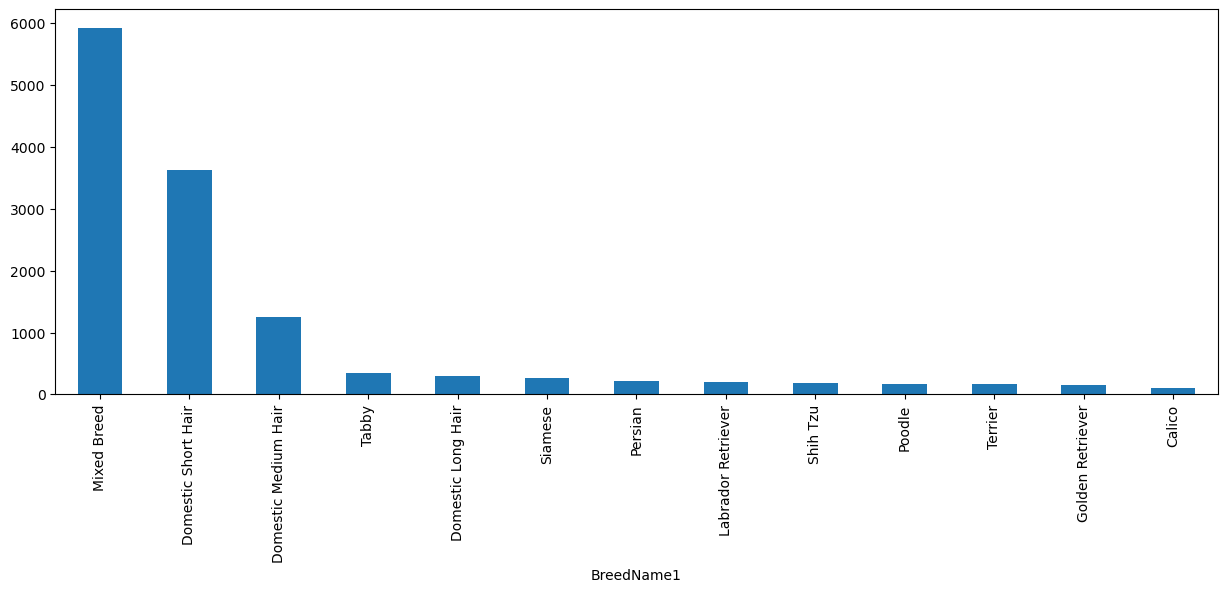

In [170]:
# Graficaos BreedName1 con más de 100 unidades
df.BreedName1.value_counts()[df.BreedName1.value_counts() > 100].plot(kind='bar', figsize=(15, 5))  


<Axes: xlabel='BreedName2'>

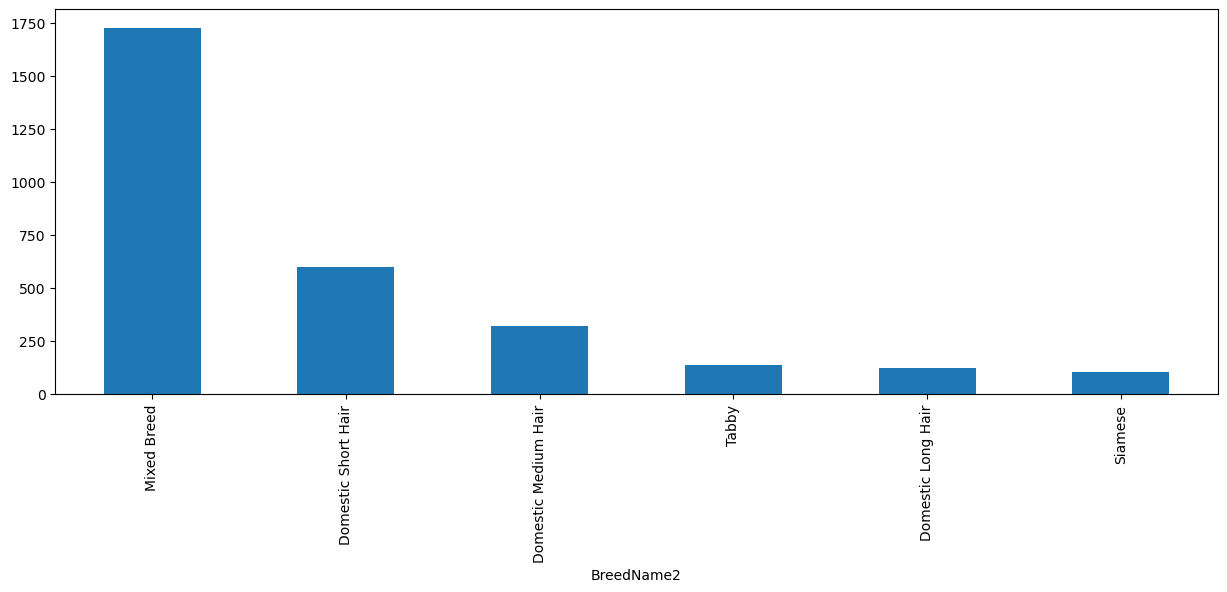

In [171]:
# Graficaos BreedName2 con más de 100 unidades
df.BreedName2.value_counts()[df.BreedName2.value_counts() > 100].plot(kind='bar', figsize=(15, 5))  

Destaca que el valor más frecuente es 'Mixed Breed' una suerte de comodín de descripción de razas.  

Las descripciones “Domestic Short Hair”, “Domestic Medium Hair” o “Domestic Long Hair” son utilizadas de forma genérica para referirse a animales (especialmente gatos) que no tienen una raza definida o registrada. Es decir, estos términos se aplican a mascotas de origen mixto o sin pedigrí, donde la única característica distintiva es la longitud del pelaje, en lugar de corresponder a un linaje o raza específica. Estos términos para los gatos son comunes en refugios y bases de datos para distinguir la apariencia del pelaje de los gatos sin pedigrí. No implican que el animal tenga una mezcla de razas específica, sino simplemente que es un gato de pelo corto, medio o largo. En perros se suele usar "Mixed Breed". 

“Tabby” no es una raza en sí misma, sino un patrón de pelaje que se observa comúnmente en los gatos domésticos. Este patrón se caracteriza por tener rayas, manchas o remolinos en el pelaje. 

### `Gender`

#### Valores Nulos

In [172]:
# Valores nulos
df.Gender.isna().sum()

0

#### Análisis Descriptivo

In [173]:
# Valores únicos
df.Gender.value_counts().sort_index()

Gender
1    5536
2    7277
3    2180
Name: count, dtype: int64

In [174]:
# Creamos una columna descriptiva de 'Gender'
Gender_map = {1: 'male', 2: 'female', 3: 'mixed'}

df['Gender_df'] = df['Gender'].map(Gender_map)

In [175]:
# Valores únicos con etiquetas
df.Gender_df.value_counts().sort_index()

Gender_df
female    7277
male      5536
mixed     2180
Name: count, dtype: int64

In [176]:
# Proporción de Valores únicos
df.Gender_df.value_counts(normalize=True).round(2).sort_index()

Gender_df
female    0.49
male      0.37
mixed     0.15
Name: proportion, dtype: float64

<Axes: xlabel='Gender_df'>

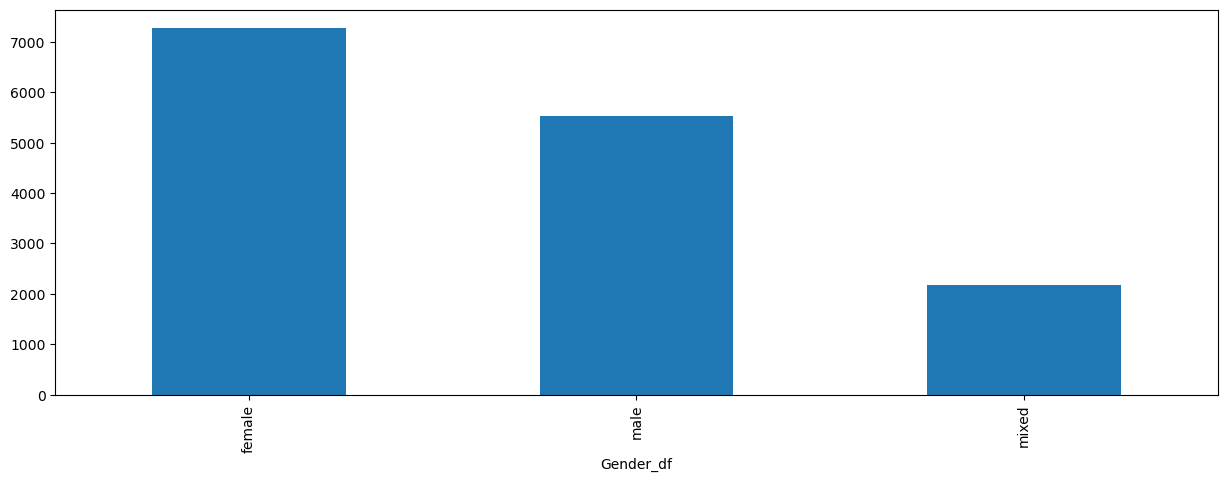

In [177]:
# Gráfico de Valores únicos con etiquetas
df.Gender_df.value_counts().plot(kind='bar', figsize=(15, 5))

#### Consideraciones de Gender
- No hay valores nulos
- El valor más frecuente (moda) es 'female'
- En algunos contextos, la categoría “mixed” puede requerir una interpretación particular, ya que puede indicar una mezcla real de géneros en el caso de que se traran de grupos.

### `Color1, Color2, Color3`

#### Valores nulos

In [178]:
# Buscamos valores nulos en el primer campo Color
df.Color1.isna().sum()

0

Hay tres campos Color, el campo Color1 no contiene valores nulos, los otros dos sí pero es lógico porque puede haber un animal de un único color. 

#### Uniificación de criterios en Color

In [179]:
# Campo descriptivo del color, podría servir
df['Color1_d'] = df['Color1'].map(df_color_labels.set_index('ColorID')['ColorName'])
df['Color2_d'] = df['Color2'].map(df_color_labels.set_index('ColorID')['ColorName'])
df['Color3_d'] = df['Color3'].map(df_color_labels.set_index('ColorID')['ColorName'])

In [180]:
# Creamos una copia con los campos requeridos
df_Color_d = df[['Color1_d', 'Color2_d', 'Color3_d']].copy()

In [181]:
# Verificamos coincidencias de colores entre los tres campos
df_Color_d['Color1_d'][(df_Color_d['Color1_d']==df['Color2_d'])
                     | (df_Color_d['Color1_d']==df['Color3_d'])
                     | (df_Color_d['Color2_d']==df['Color3_d'])].count()

0

In [182]:
# Creamos un campo color_n que contabiliza la cantidad de colores por fila
df['color_n'] = (df[['Color1', 'Color2', 'Color3']]>0).sum(axis=1)

# Verificar el resultado
print(df[['Color1', 'Color2', 'Color3', 'color_n']].head())

   Color1  Color2  Color3  color_n
0       1       7       0        2
1       1       2       0        2
2       2       7       0        2
3       1       2       0        2
4       1       0       0        1


In [183]:
# Verificar la cantidad de filas agrupados por cantidad de colores
df.color_n.value_counts().sort_index()

color_n
1    4471
2    6133
3    4389
Name: count, dtype: int64

In [184]:
# Verificar la cantidad de filas agrupados por cantidad de colores
df.color_n.value_counts(normalize=True).round(3).sort_index()

color_n
1    0.298
2    0.409
3    0.293
Name: proportion, dtype: float64

Esto podria servir para ver si animales de distintos colores se adoptan más

<Axes: xlabel='color_n'>

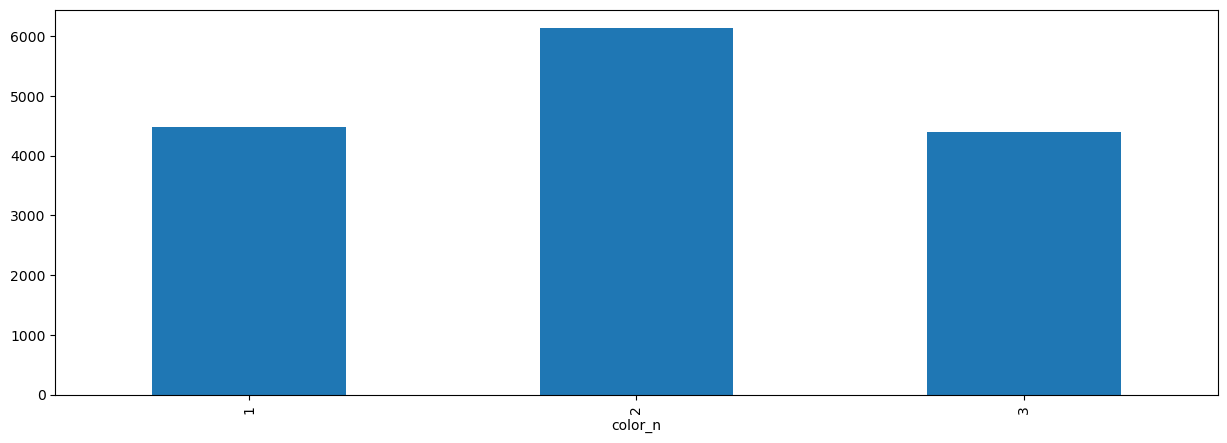

In [185]:
df.color_n.value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

En el 40% de los casos firguran animales de dos colores, resultado de uno y tres colores 30% respectivamente.

## `MaturitySize`
El campo MaturitySize indica el tamaño que se espera que tenga la mascota una vez que ha alcanzado su madurez. En el contexto del dataset PetFinder.my, este campo suele codificarse de forma ordinal (por ejemplo, valores numéricos que representan “pequeño”, “mediano”, “grande” o incluso una escala más detallada) y permite distinguir entre mascotas que, al madurar, serán de menor o mayor tamaño.

Utilidad en el EDA
	- Segmentación:
Permite agrupar a los animales según su tamaño maduro, lo que puede ser relevante para analizar comportamientos de adopción, necesidades de espacio, o preferencias de los adoptantes.
	- Relación con Otras Variables:
Al cruzarlo con otras características (como la raza, la edad o el tipo de mascota), se pueden identificar patrones o correlaciones interesantes. Por ejemplo, quizá las mascotas de mayor tamaño se adopten a diferentes ritmos que las de menor tamaño.
	•- Perfil del Animal:
Conocer el tamaño maduro ayuda a construir un perfil más completo de la mascota, lo que puede influir en decisiones de marketing o en la creación de estrategias específicas para diferentes segmentos de animales.

MaturitySize es una variable clave para comprender las expectativas de tamaño de las mascotas y su posible impacto en otros aspectos del comportamiento de adopción o en el manejo de los animales.

In [186]:
# Valores nulos
df.MaturitySize.isna().sum()

0

In [187]:
# Valores únicos
df.MaturitySize.value_counts().sort_index() 


MaturitySize
1     3395
2    10305
3     1260
4       33
Name: count, dtype: int64

In [188]:
# Creamos una columna descriptiva de 'MaturitySize'
MaturitySize_map = {1: 'pequeño', 2: 'mediano', 3: 'grande', 4: 'muy grande'}

df['MaturitySize_df'] = df['MaturitySize'].map(MaturitySize_map)

In [189]:
# Valores únicos con etiquetas
df.MaturitySize_df.value_counts().sort_index()

MaturitySize_df
grande         1260
mediano       10305
muy grande       33
pequeño        3395
Name: count, dtype: int64

In [190]:
# Proporción de Valores únicos
df.MaturitySize_df.value_counts(normalize=True).round(2).sort_index()

MaturitySize_df
grande        0.08
mediano       0.69
muy grande    0.00
pequeño       0.23
Name: proportion, dtype: float64

<Axes: xlabel='MaturitySize_df'>

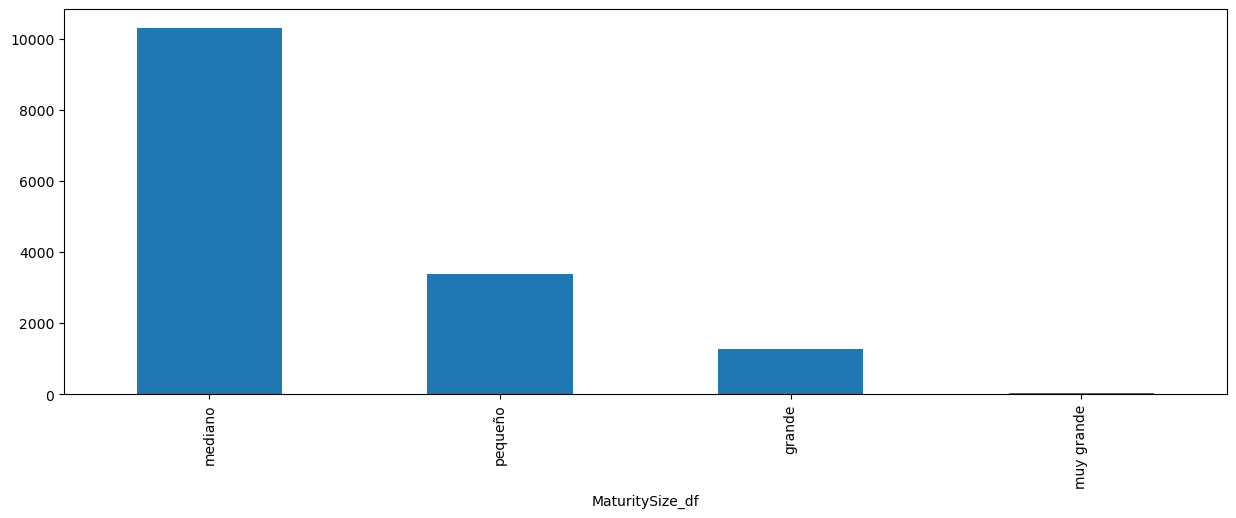

In [191]:
# Gráfico de Valores únicos con etiquetas
df.MaturitySize_df.value_counts().plot(kind='bar', figsize=(15, 5))

En este dataset la variable `MaturitySize` (tamaño en la madurez), se concentra mayoritariamente en los valores “mediano” y “pequeño”, con una proporción reducida de “grande” y “muy grande”. Esto sugiere que la mayoría de las mascotas en la base de datos no llegan a un tamaño grande en la edad adulta, lo cual puede ser un factor relevante para entender la oferta de mascotas y los patrones de adopción.

## `FurLength`
La variable `FurLength` se refiere a la longitud del pelaje de la mascota. Es una variable ordinal categórica codificada numéricamente, que describe si el animal tiene el pelo corto, mediano o largo.

Codificación habitual:
- 1: Pelaje corto (Short)
- 2: Pelaje mediano (Medium)
- 3: Pelaje largo (Long)


In [192]:
# Creamos una columna descriptiva de 'FurLength'
FurLength_map = {1: 'corto', 2: 'mediano', 3: 'largo'}

df['FurLength_df'] = df['FurLength'].map(FurLength_map)

In [193]:
# Valores Nulos
df.FurLength.isna().sum()

0

In [194]:
df.FurLength.value_counts().sort_index()

FurLength
1    8808
2    5361
3     824
Name: count, dtype: int64

In [195]:
# Proporción de Valores únicos
df.FurLength.value_counts(normalize=True).round(2).sort_index()

FurLength
1    0.59
2    0.36
3    0.05
Name: proportion, dtype: float64

<Axes: xlabel='FurLength_df'>

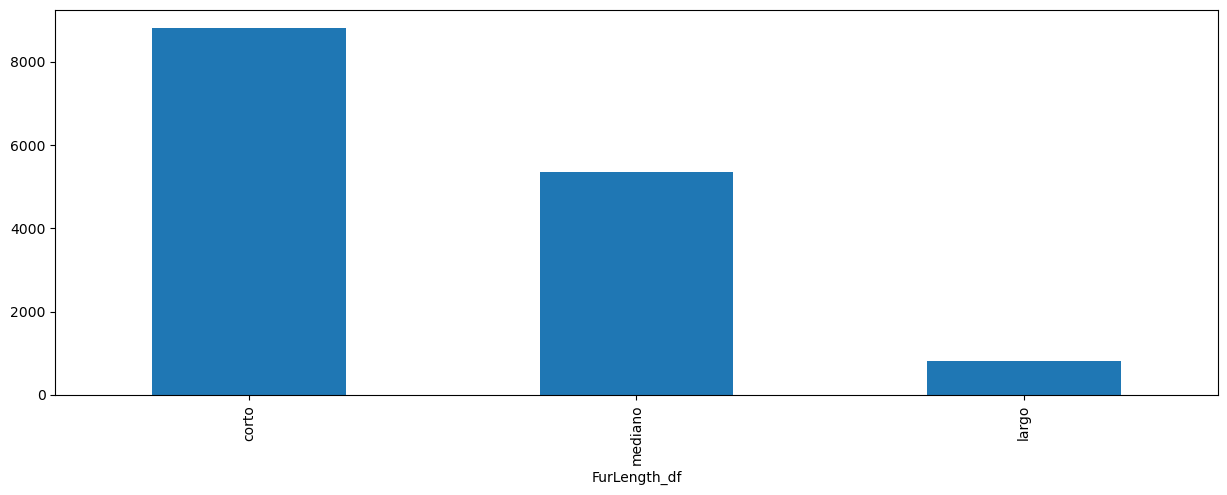

In [196]:
# Gráfico de Valores únicos con etiquetas
df.FurLength_df.value_counts().plot(kind='bar', figsize=(15, 5))

`FurLength` es una variable descriptiva del aspecto físico del animal que puede ser relevante tanto para fines analíticos como para modelos predictivos relacionados con adopción.

Su objetivo es indicar visual y funcionalmente cómo es el pelaje del animal, lo cual puede influir en:
- Preferencias de adopción (algunas personas prefieren mascotas de pelo corto por menor mantenimiento).
- Cuidados requeridos (pelajes largos requieren más higiene y cepillado).
- Percepción estética o de raza (algunas razas se asocian con cierto tipo de pelaje).

### `Vaccinated`

In [197]:
# Valores nulos
df.Vaccinated.isna().sum()

0

In [198]:
# Valores únicos
df.Vaccinated.value_counts().sort_index()

Vaccinated
1    5898
2    7227
3    1868
Name: count, dtype: int64

In [199]:
# Creamos una columna descriptiva de 'Vaccinated'
vaccinated_map = {1: 'yes', 2: 'no', 3: 'not sure'}

df['vaccinated_df'] = df['Vaccinated'].map(vaccinated_map)

In [200]:
# Valores únicos con etiquetas
df.vaccinated_df.value_counts().sort_values(ascending=False)

vaccinated_df
no          7227
yes         5898
not sure    1868
Name: count, dtype: int64

In [201]:
# Proporción de Valores únicos
df.vaccinated_df.value_counts(normalize=True).round(2).sort_values(ascending=False)

vaccinated_df
no          0.48
yes         0.39
not sure    0.12
Name: proportion, dtype: float64

<Axes: xlabel='vaccinated_df'>

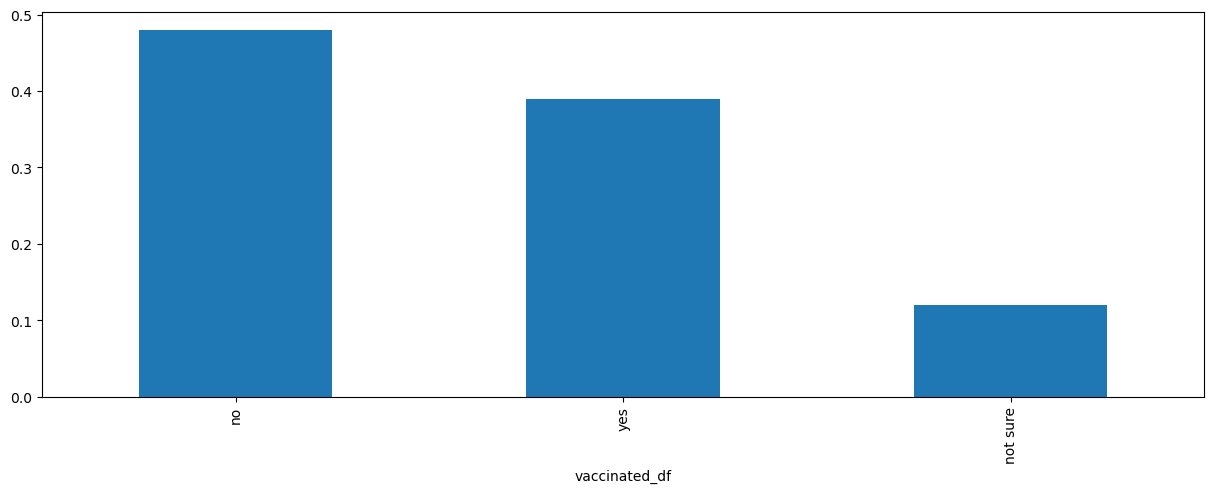

In [202]:
# Gráfico de Valores únicos con etiquetas
df.vaccinated_df.value_counts(normalize=True).round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

#### Consideraciones de Vaccinated
- No hay valores nulos
- El valor más frecuente (moda) es 'no', seguido por 'yes', alrededor del 10% no hay seguridad.


### `Dewormed`

In [203]:
# Valores nulos
df.Dewormed.isna().sum()

0

In [204]:
# Valores únicos
df.Dewormed.value_counts().sort_index()

Dewormed
1    8397
2    4815
3    1781
Name: count, dtype: int64

In [205]:
# Creamos una columna descriptiva de 'Dewormed'
dewormed_map = {1: 'yes', 2: 'no', 3: 'not sure'}

df['dewormed_df'] = df['Dewormed'].map(dewormed_map)

In [206]:
# Valores únicos con etiquetas
df.dewormed_df.value_counts().sort_values(ascending=False)

dewormed_df
yes         8397
no          4815
not sure    1781
Name: count, dtype: int64

In [207]:
# Proporción de Valores únicos
df.dewormed_df.value_counts(normalize=True).round(2).sort_values(ascending=False)

dewormed_df
yes         0.56
no          0.32
not sure    0.12
Name: proportion, dtype: float64

<Axes: xlabel='dewormed_df'>

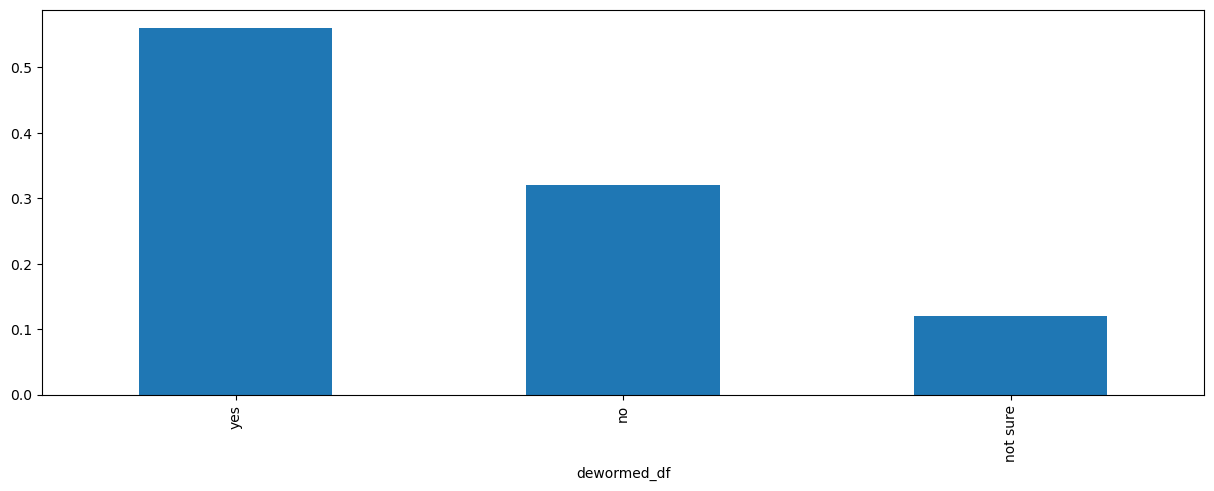

In [208]:
# Gráfico de Valores únicos con etiquetas
df.dewormed_df.value_counts(normalize=True).round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

#### Consideraciones de Dewormed
- No hay valores nulos
- El valor más frecuente (moda) es 'yes', seguido por 'no', alrededor del 10% no hay seguridad.


### `Sterilized`

In [209]:
# Valores nulos
df.Sterilized.isna().sum()

0

In [210]:
# Valores únicos
df.Sterilized.value_counts().sort_index()

Sterilized
1     3101
2    10077
3     1815
Name: count, dtype: int64

In [211]:
# Creamos una columna descriptiva de 'Sterilized'
sterilized_map = {1: 'yes', 2: 'no', 3: 'not sure'}

df['sterilized_df'] = df['Sterilized'].map(sterilized_map)

In [212]:
# Valores únicos con etiquetas
df.sterilized_df.value_counts().sort_values(ascending=False)

sterilized_df
no          10077
yes          3101
not sure     1815
Name: count, dtype: int64

In [213]:
# Proporción de Valores únicos
df.sterilized_df.value_counts(normalize=True).round(2).sort_values(ascending=False)

sterilized_df
no          0.67
yes         0.21
not sure    0.12
Name: proportion, dtype: float64

<Axes: xlabel='sterilized_df'>

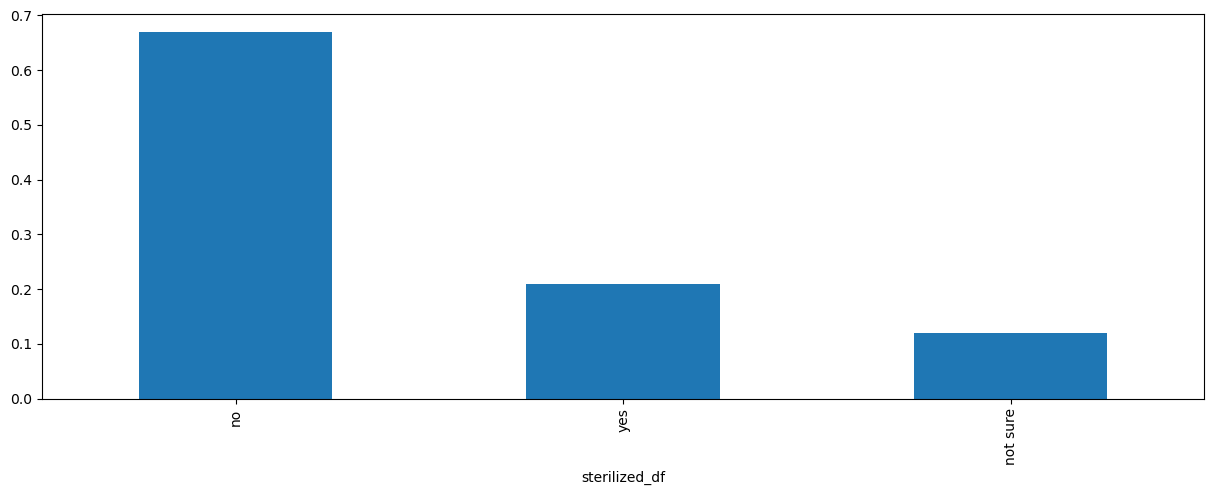

In [214]:
# Gráfico de Valores únicos con etiquetas
df.sterilized_df.value_counts(normalize=True).round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

#### Consideraciones de Sterilized
- No hay valores nulos
- El valor más frecuente (moda) es 'no', seguido por 'yes' en un 20%, alrededor del 10% no hay seguridad.


### `Health`

In [215]:
# Valores nulos
df.Health.isna().sum()

0

In [216]:
# Valores únicos
df.Health.value_counts().sort_index()

Health
1    14478
2      481
3       34
Name: count, dtype: int64

In [217]:
# Creamos una columna descriptiva de 'Health'
health_map = {1: 'healthy', 2: 'minor', 3: 'serious'}

df['health_df'] = df['Health'].map(health_map)

In [218]:
# Valores únicos con etiquetas
df.health_df.value_counts().sort_values(ascending=False)

health_df
healthy    14478
minor        481
serious       34
Name: count, dtype: int64

In [219]:
# Proporción de Valores únicos
df.health_df.value_counts(normalize=True).round(2).sort_values(ascending=False)

health_df
healthy    0.97
minor      0.03
serious    0.00
Name: proportion, dtype: float64

<Axes: xlabel='health_df'>

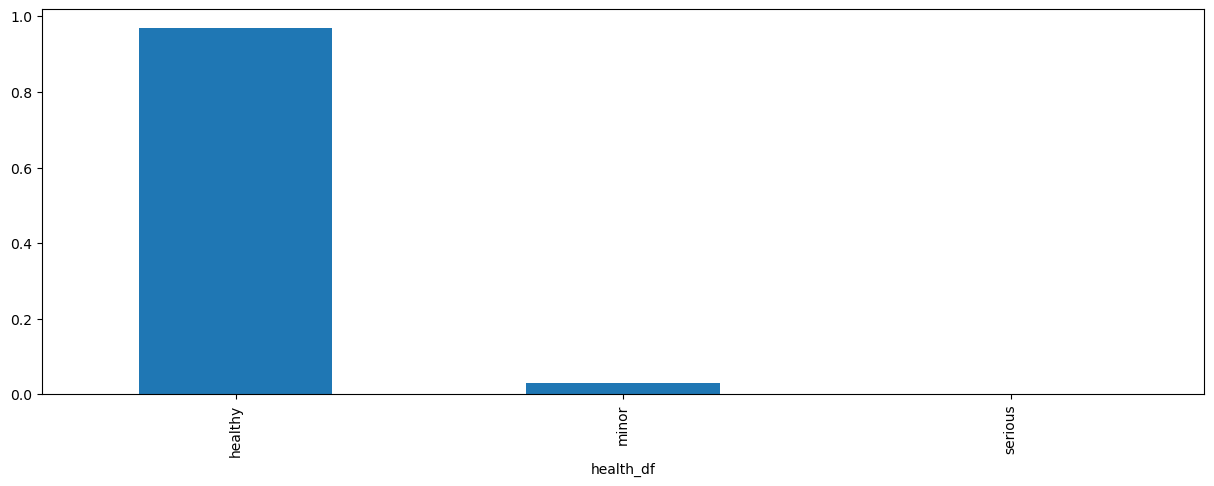

In [220]:
# Gráfico de Valores únicos con etiquetas
df.health_df.value_counts(normalize=True).round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Columns: 186 entries, Type_x to BreedName2
dtypes: category(1), float64(3), int32(2), int64(155), object(25)
memory usage: 21.1+ MB


### Quantity

In [222]:
# Valores nulos
df.Quantity.isna().sum()   

0

In [223]:
# Valores negativos
df['Quantity'][df['Quantity']<0].count()

0

In [224]:
# Valores de tendencia central y dispersión
df.Quantity.describe()

count    14993.000000
mean         1.576069
std          1.472477
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         20.000000
Name: Quantity, dtype: float64

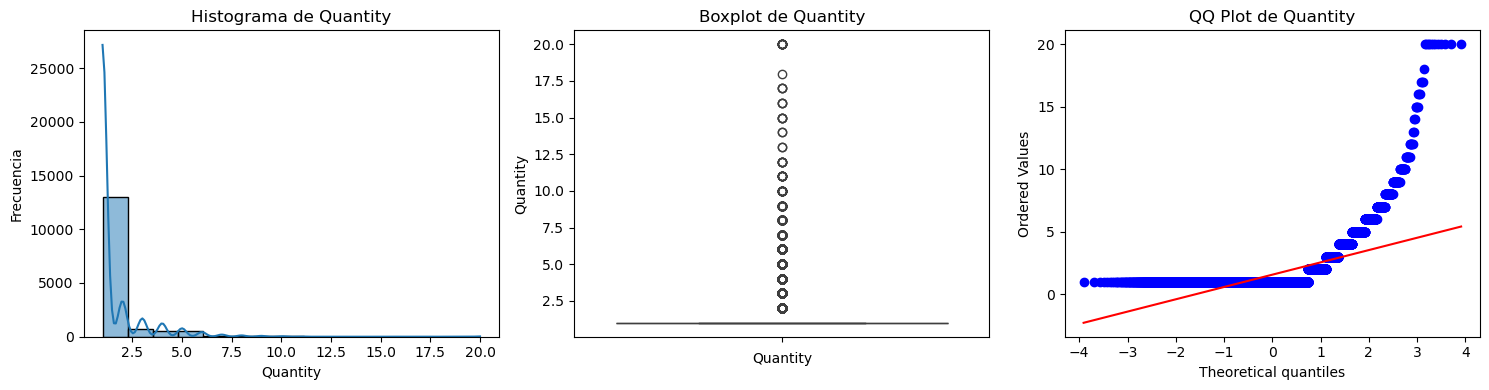

In [225]:
# Gráficos de distribución
graficos_distribucion(df, 'Quantity')

In [226]:
# Test de normalidad    
analizar_normalidad(df, 'Quantity')


--- Normalidad para Quantity ---
Shapiro-Wilk: W=0.4470, p=0.0000 -> No normal
D’Agostino-Pearson: stat=14292.4738, p=0.0000 -> No normal
Anderson-Darling: A=3137.0352
  Nivel 15.0%: crítico=0.5760 -> No normal
  Nivel 10.0%: crítico=0.6560 -> No normal
  Nivel 5.0%: crítico=0.7870 -> No normal
  Nivel 2.5%: crítico=0.9180 -> No normal
  Nivel 1.0%: crítico=1.0920 -> No normal


c:\Users\adria\anaconda3\envs\ldi2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14993.
  res = hypotest_fun_out(*samples, **kwds)


El campo `Quantity` muestra una distribución no normal, sin valores nulos o negativos.

In [227]:
df.Quantity.value_counts()

Quantity
1     11565
2      1422
3       726
4       531
5       333
6       185
7        84
8        52
9        33
10       19
20       12
11       10
12        6
15        4
17        3
16        3
14        2
13        2
18        1
Name: count, dtype: int64

<Axes: xlabel='Quantity'>

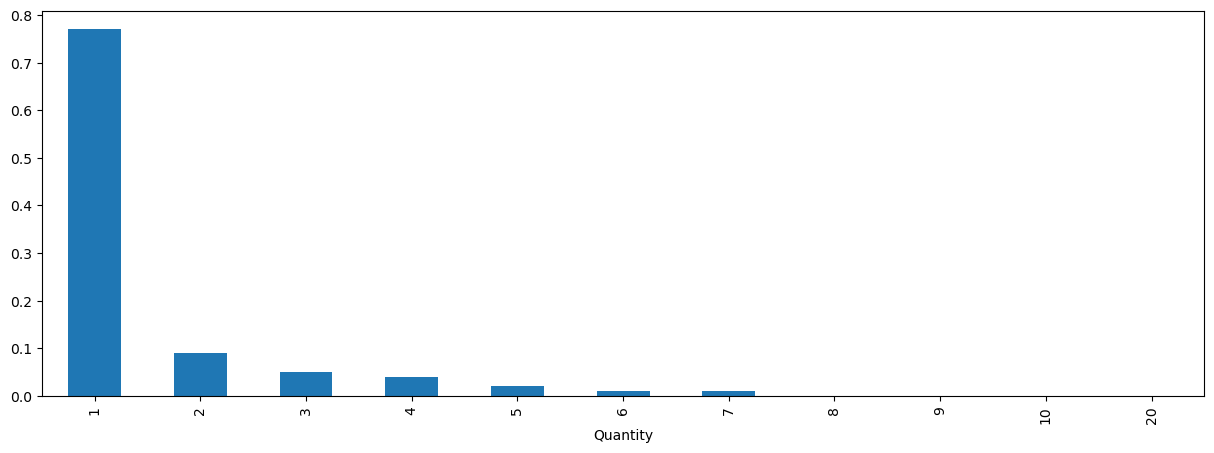

In [228]:
# Gráfico de Valores únicos con etiquetas
df.Quantity.value_counts(normalize=True)[df.Quantity.value_counts() > 10].round(2).sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

## `Fee`

In [229]:
df.Fee.value_counts()

Fee
0      12663
50       468
100      408
200      219
150      162
       ...  
170        1
135        1
14         1
89         1
190        1
Name: count, Length: 74, dtype: int64

La mayoria de las adopciones no tienen fee (son gratis), se comporat como variable categórica a segmentar, gratis o no gratis x ejemplo.

In [230]:
# Crear un nuevo DataFrame sin Fee = 0
df_fee_nonzero = df[df['Fee'] != 0]

In [231]:
df_fee_nonzero.Fee.value_counts(normalize=True).round(2).sort_values(ascending=False)[df_fee_nonzero.Fee.value_counts() > 50]

Fee
50     0.20
100    0.18
200    0.09
150    0.07
20     0.06
300    0.05
30     0.04
250    0.04
1      0.04
10     0.03
80     0.03
500    0.02
Name: proportion, dtype: float64

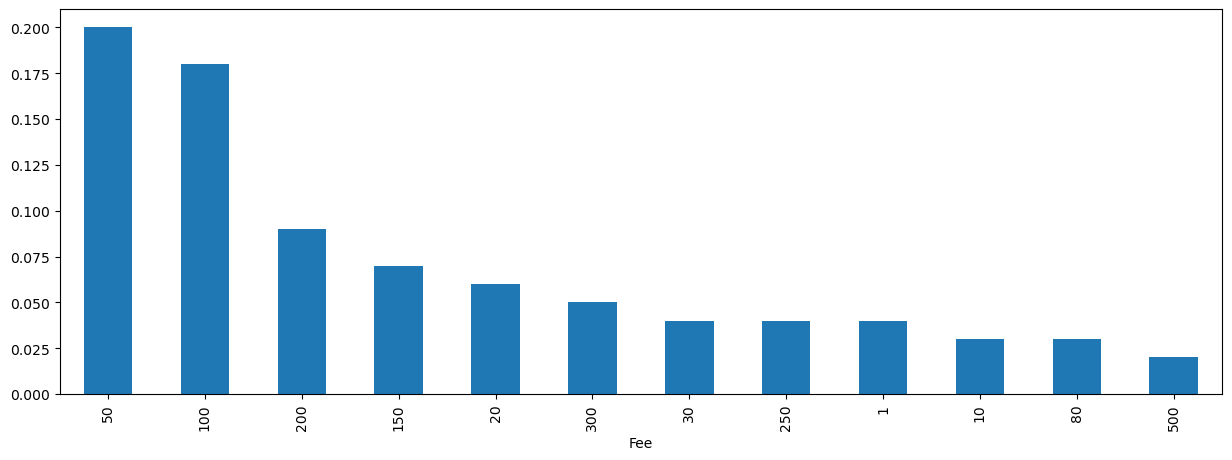

In [232]:
# Gráfico de Valores únicos con etiquetas sin 0
df_fee_nonzero.Fee.value_counts(normalize=True).round(2).sort_values(ascending=False)[df_fee_nonzero.Fee.value_counts() > 50].plot(kind='bar', figsize=(15, 5));

In [233]:
df['Fee_paga'] = np.where(df['Fee'] != 0, 'paga', 'gratis')

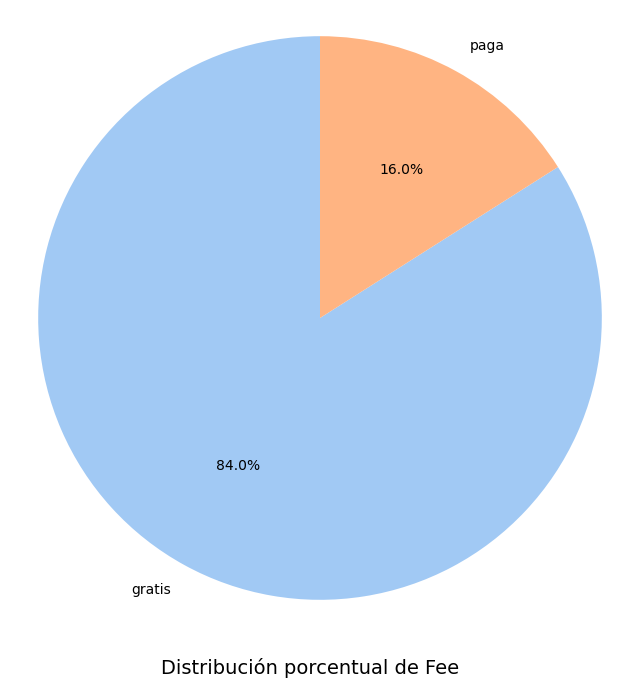

In [234]:
fee_paga_counts = df['Fee_paga'].value_counts(normalize=True).sort_index().round(2)
colors = sns.color_palette('pastel')[0:2]

# Crear figura y gráfico
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(fee_paga_counts, labels=fee_paga_counts.index,
       autopct='%1.1f%%', colors=colors, startangle=90)
ax.axis('equal')  # Círculo perfecto

# Título abajo
fig.text(0.5, 0.05, 'Distribución porcentual de Fee', ha='center', fontsize=14)
plt.show()

- `Fee` tiene una mayoria de datos en valor 0, es decir adopciones gratuitas
- Del total de pagas cerca del 40% corresponden a adopciones de 50 o 100 dolares de monto.

### Análisis de Correlación

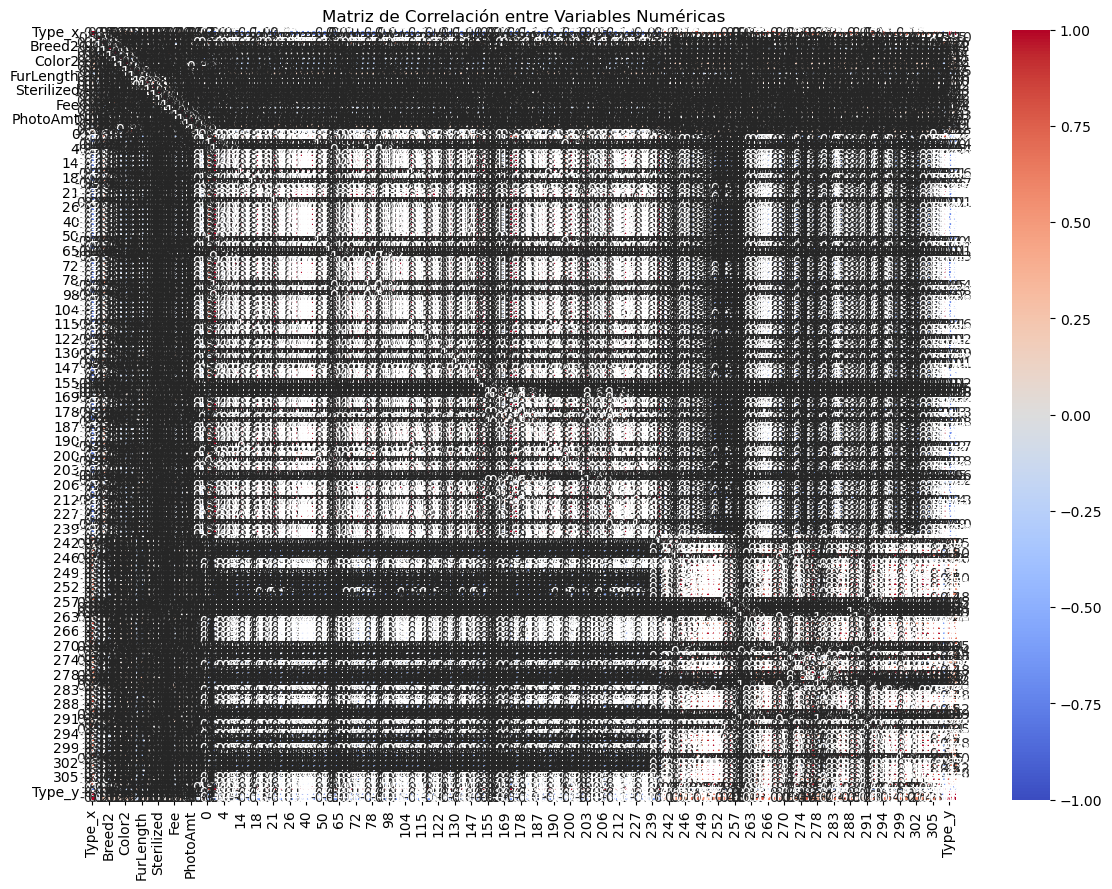

In [235]:
# Seleccionar solo columnas numéricas (int y float)
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Matriz de correlación
correlation_matrix = numeric_df.corr()

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin = -1)
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

- Los campos con correlaciones positivas en 0.10 y 0.11 son Age y Breed1 respectivamente, lo cual indica que a medida que aumenta la edad de la mascota, tiende a aumentar el valor de AdoptionSpeed, es decir, tardan más en ser adoptadas.
- Type y FurLength tiene -0.09 y Sterilized -0.08, loc ual significaría que los perros tienden a ser adoptados más rápido que los gatos, ya que valores mayores de Type (gato) se asocian con valores mayores de AdoptionSpeed (más lenta adopción). En forma similar, mascotas con mayor longitud de pelo o esterilizadas tienden a ser adoptadas más rápidamente.
- Vaccinated y Dewormed se encuentran correclacionadas (r = 0.72), así como con Sterilized (0.47 y 0.43 respectivamente)


## ETAPA 3: Análisis Bivariado con Target

### Relación con `AdoptionSpeed`
### Con `Type`
#### Visualización de la distribución de AdoptionSpeed por Type
- Gráfico de barras agrupadas: Muestra la frecuencia absoluta de cada nivel de AdoptionSpeed para cada Type.
-Gráfico de barras apiladas o de proporciones: Permite ver las proporciones relativas.

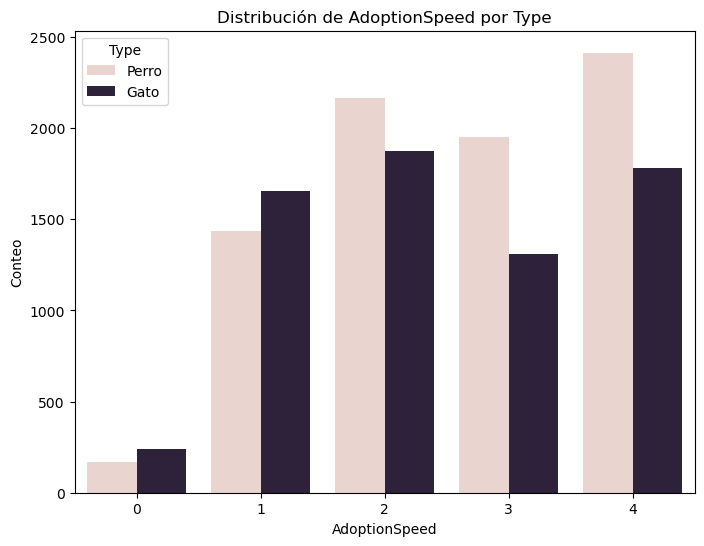

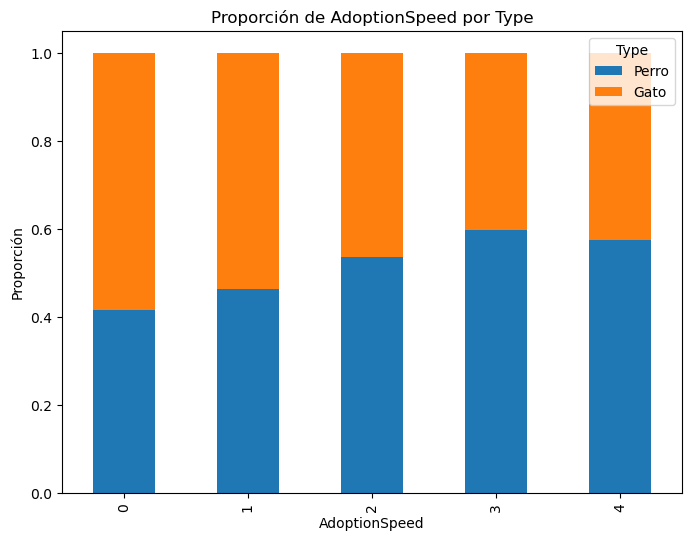

In [102]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='Type')
plt.title('Distribución de AdoptionSpeed por Type')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Type', labels=['Perro', 'Gato'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_Vaccinated_ct = pd.crosstab(df['AdoptionSpeed'], df['Type'], normalize='index')
adoption_Vaccinated_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por Type')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='Type', labels=['Perro', 'Gato'])  # Ajusta según la codificación real
plt.show()

##### Consideraciones de la visualización entre `AdoptionSpeed` y `Type`
- `AdoptionSpeed` 0 (adopción más rápida): Tanto perros como gatos presentan relativamente pocos casos en la categoría 0, lo que indica que no es muy común que las mascotas sean adoptadas “inmediatamente”.
- `AdoptionSpeed` intermedios (1, 2, 3): La mayor concentración de casos para ambos tipos se ubica en los valores 2 y 3. Los perros parecen tener un pico ligeramente mayor en AdoptionSpeed 2 y 4, mientras que los gatos muestran un recuento un poco más alto en AdoptionSpeed 3.
- `AdoptionSpeed` 4 (adopción más tardía o no adoptado): Se ve que los perros tienen un conteo algo mayor en el nivel 4, en comparación con los gatos, lo que podría indicar que, proporcionalmente, hay más perros que terminan adoptados muy tarde (o incluso no adoptados).
- El gráfico indica que no todas las mascotas se adoptan con la misma rapidez. Hay un grupo pequeño en la categoría 0 (adopción muy rápida), un volumen considerable en las categorías 2 y 3, y un grupo notable en la categoría 4. Parecería que, visualmente, que el tipo de mascota (perro vs. gato) podría influir en la rapidez de adopción. Los perros tienen mayor conteo en los extremos (0 y 4), mientras que los gatos se concentran un poco más en las categorías intermedias.
- Finalmente, el gráfico sugiere que, si bien hay similitudes en las distribuciones de perros y gatos, sí existen diferencias importantes en los niveles de `AdoptionSpeed`, sobre todo en la categoría más tardía (4). 

### Con `Age`
#### Análisis Descriptivo de la distribución de `Age` segun `AdoptionSpeed`


In [103]:
# Estadísticas descriptivas de Age agrupadas por AdoptionSpeed
age_summary = df.groupby('AdoptionSpeed')['Age'].describe()
print(age_summary)

                count       mean        std  min  25%  50%   75%    max
AdoptionSpeed                                                          
0               410.0  10.451220  17.775118  0.0  2.0  3.0  12.0  120.0
1              3090.0   8.488350  15.746187  0.0  2.0  2.0   6.0  147.0
2              4037.0   8.823631  16.779013  0.0  2.0  3.0   6.0  156.0
3              3259.0  10.189936  18.672104  0.0  2.0  3.0   9.0  212.0
4              4197.0  13.667858  20.177460  0.0  3.0  6.0  15.0  255.0


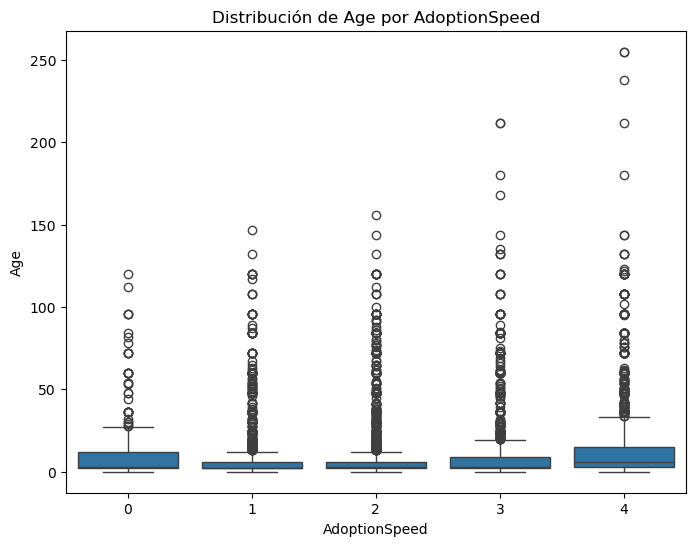

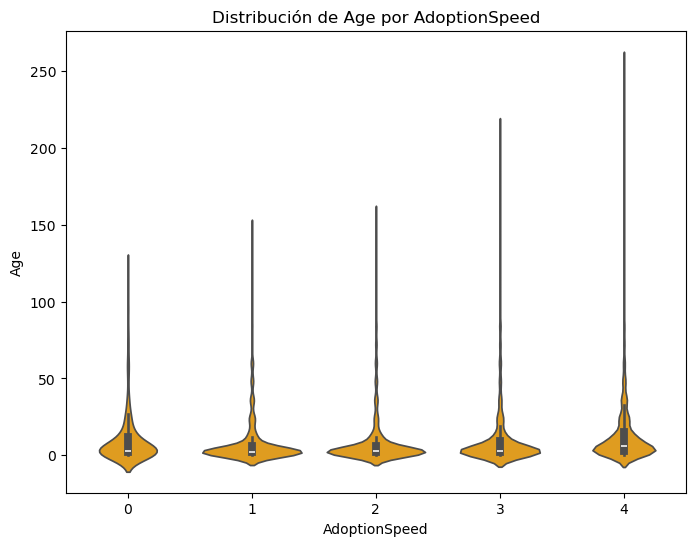

In [104]:
# Gráfico de caja (boxplot)
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='AdoptionSpeed', y='Age')
plt.title('Distribución de Age por AdoptionSpeed')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Age')
plt.show()

# Gráfico de violín
plt.figure(figsize=(8,6))
sns.violinplot(data=df, x='AdoptionSpeed', y='Age', color='orange')
plt.title('Distribución de Age por AdoptionSpeed')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Age')
plt.show()

#### Test Estadísticos


In [105]:
# Extraer la variable Age para cada grupo de AdoptionSpeed
groups = [group["Age"].values for name, group in df.groupby("AdoptionSpeed")]

# Realizar el test de Kruskal-Wallis
stat, p_value = kruskal(*groups)
print("Kruskal-Wallis stat:", stat)
print("p-value:", p_value)

Kruskal-Wallis stat: 823.1138148978662
p-value: 7.561186820617216e-177


Consideraciones:
1.	Distribución Altamente Sesgada (Skewed)
	- En ambos gráficos se aprecia que la mayoría de los datos de la edad se concentran cerca de valores bajos (en la parte inferior), mientras que existe un número significativo de valores atípicos que se extienden hacia la parte superior (algunos llegan hasta o superan los 200).
	- Esto sugiere que la edad de la mayoría de las mascotas es relativamente baja, pero hay una minoría de casos con edades muy elevadas.
2.	Medianas Similares entre Categorías
	- Tanto en el boxplot como en el violin plot, se observa que la mediana de la edad (la línea dentro de cada “caja” o el recuadro en la parte más densa del violín) se ubica en un rango relativamente cercano para todas las categorías de AdoptionSpeed (0 a 4).
	- Esto indica que, en promedio, las mascotas adoptadas muy rápido (AdoptionSpeed=0) no difieren sustancialmente en edad de aquellas que tardan más (AdoptionSpeed=4).
3.	Presencia de Outliers
	- Los puntos que aparecen por encima de los “bigotes” (whiskers) en el boxplot se consideran valores atípicos, reflejando edades mucho mayores que la mayoría de las observaciones.
	- La extensión vertical en los violin plots corrobora que, aunque la mayoría de los registros se concentran en edades más jóvenes, hay un grupo reducido con edades muy altas.
4.	Densidad y Forma de la Distribución
	- El violin plot muestra la densidad de la edad en cada categoría de AdoptionSpeed. Cada “violín” es bastante estrecho en la parte superior, lo que confirma que hay menos mascotas con edades muy elevadas, pero al mismo tiempo el rango máximo llega a valores altos.
	- En la parte inferior, los “violines” se ensanchan, señal de que la mayoría de las mascotas se encuentran en edades bajas (con un pico de densidad concentrado en los primeros meses/años).
5.	Conclusión Preliminar
	- Visualmente, no se observan diferencias drásticas en la edad promedio o mediana a medida que varía la velocidad de adopción. Aunque la edad de la mascota podría tener un impacto en la velocidad de adopción. Si se observa que existen diferencias significativas y con un tamaño de efecto razonable, `Age` puede ser una variable importante en modelos predictivos.
	

### Con `Breed1` y `Breed2`

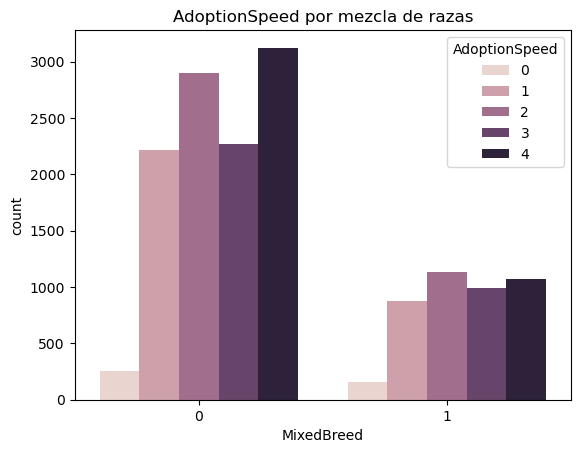

In [106]:
# Breed1 y Breed2 combinadas
df['MixedBreed'] = (df['Breed2'] != 0).astype(int)
plt.figure()
sns.countplot(x='MixedBreed', hue='AdoptionSpeed', data=df)
plt.title('AdoptionSpeed por mezcla de razas')
plt.show()

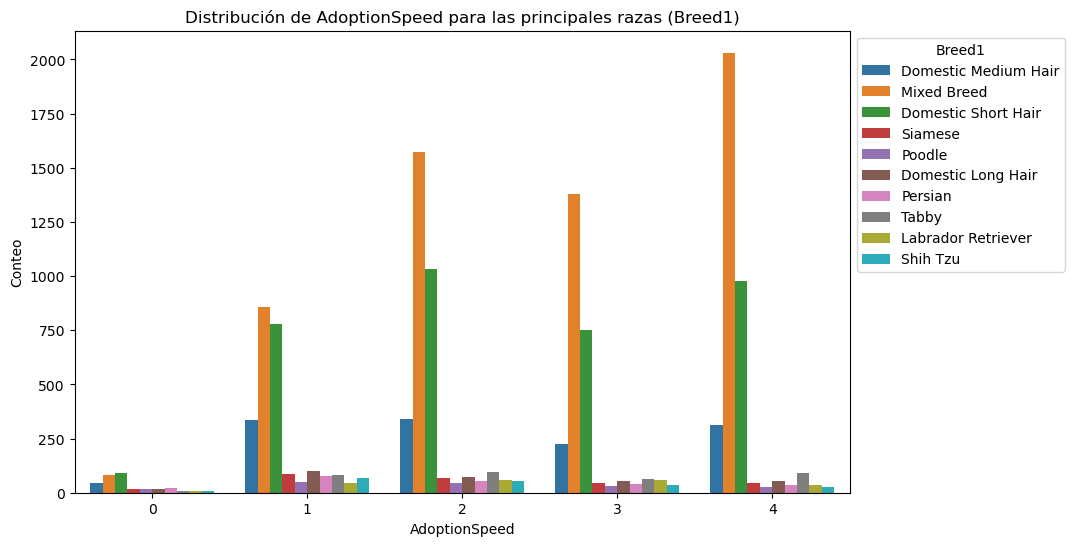

In [107]:
# Ejemplo: filtrar para las 10 razas más comunes en Breed1 y analizar AdoptionSpeed
top_breeds = df['BreedName1'].value_counts().head(10).index
# Suponiendo que el dataset principal 'df' tenga una columna 'Breed1' y 'AdoptionSpeed'
df_top = df[df['BreedName1'].isin(top_breeds)]

plt.figure(figsize=(10,6))
sns.countplot(data=df_top, x='AdoptionSpeed', hue='BreedName1')
plt.title('Distribución de AdoptionSpeed para las principales razas (Breed1)')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Breed1', bbox_to_anchor=(1,1))
plt.show()

#### Consideraciones
Este gráfico muestra la distribución de la variable AdoptionSpeed desagregada por las 10 razas más frecuentes en la columna Breed1.

1. Dominancia de Mixed Breed y Domestic Short Hair
- Mixed Breed (verde) es, por lejos, la raza más representada en todas las categorías de AdoptionSpeed, especialmente en las más lentas (3 y 4).
- Domestic Short Hair también tiene una fuerte presencia, aunque menos marcada, pero con una distribución similar.
- Las razas comunes o sin pedigrí tienden a demorar más en ser adoptadas, posiblemente por menor “atractivo de raza”.

2. Razas con adopciones más rápidas
- Razas como Shih Tzu, Poodle, y Labrador Retriever muestran menor representación general, pero distribución más pareja o sesgada hacia adopciones más rápidas (AdoptionSpeed 0, 1 y 2).
- Razas pequeñas, conocidas o “familiares” tienden a generar adopción más temprana (posible preferencia del adoptante).

3. Domestic Medium y Long Hair
- Estas razas tienen comportamiento intermedio, sin una tendencia clara pero aparecen con frecuencia moderada en todas las clases.
- Podria haber un impacto del pelaje en la percepción del adoptante, aunque no es concluyente.

4. Tabby y Persian
- Aunque menos frecuentes, tienen un patrón más concentrado en adopciones tardías (3 y 4), sugiriendo menor demanda o dificultad de colocación.


## Con `Gender`

In [108]:
df['Gender'].value_counts()

Gender
2    7277
1    5536
3    2180
Name: count, dtype: int64

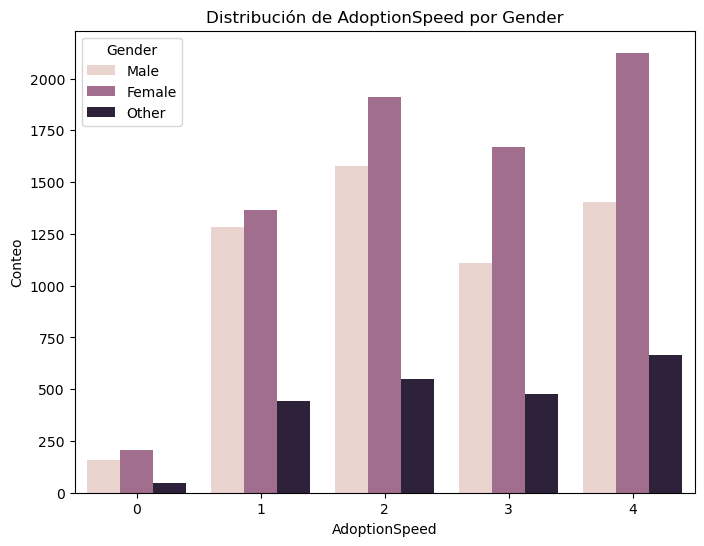

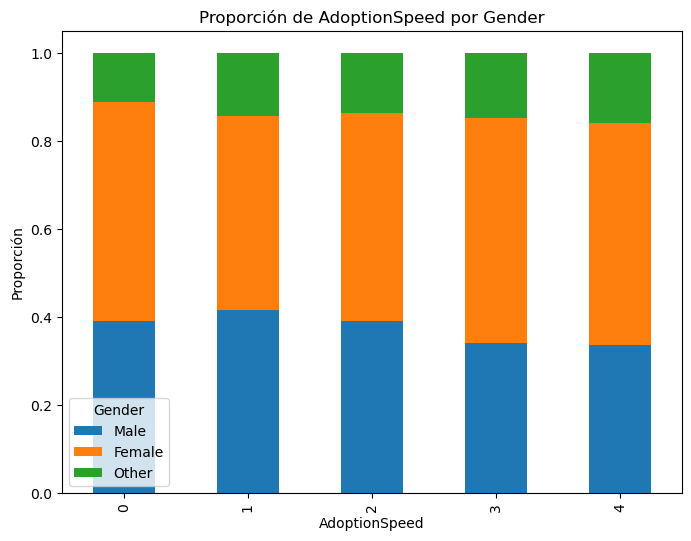

In [109]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='Gender')
plt.title('Distribución de AdoptionSpeed por Gender')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Gender', labels=['Male', 'Female', 'Other'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_Gender_ct = pd.crosstab(df['AdoptionSpeed'], df['Gender'], normalize='index')
adoption_Gender_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por Gender')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='Gender', labels=['Male', 'Female', 'Other'])  # Ajusta según la codificación real
plt.show()

Estos dos gráficos exploran la relación entre el género de la mascota (Gender) y la variable objetivo AdoptionSpeed. 

- Gráfico 1: Distribución absoluta (countplot)
	1.	Female (naranja) es consistentemente el género con más casos en todos los niveles de AdoptionSpeed.
	2.	Male (azul) aparece con frecuencia similar pero algo menor.
	3.	Other (verde) representa un grupo minoritario, pero no despreciable, con presencia algo mayor en adopciones más lentas.
    - Las mascotas femeninas son más comunes en el dataset. La distribución sugiere una ligera ventaja en frecuencia de adopción rápida para hembras, aunque no drásticamente.

- Gráfico 2: Proporción (normalized stacked barplot)
	1.	Female representa consistentemente más del 50% en todas las categorías de AdoptionSpeed.
	2.	Male se mantiene entre 30–40%, con ligera caída en adopciones lentas (clases 3 y 4).
	3.	Other representa alrededor del 10–15% y se mantiene bastante constante.

    - Las proporciones son relativamente estables, aunque hay una tendencia levemente mayor de adopción rápida entre hembras.
    - La categoría Other no muestra cambios relevantes, pero su menor volumen sugiere un posible sesgo o escasa utilización del campo.

Aunque las diferencias no son grandes, las hembras tienen una ligera ventaja tanto en frecuencia como en rapidez de adopción.


## Con `MaturitySize`

In [110]:
df['MaturitySize'].value_counts()

MaturitySize
2    10305
1     3395
3     1260
4       33
Name: count, dtype: int64

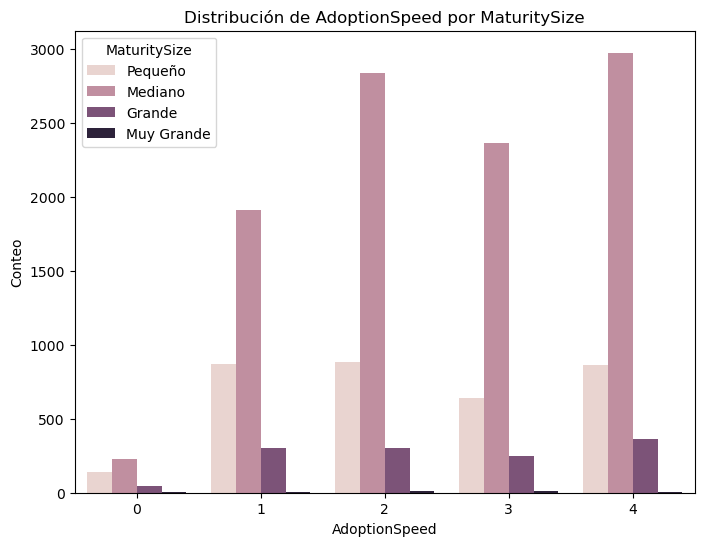

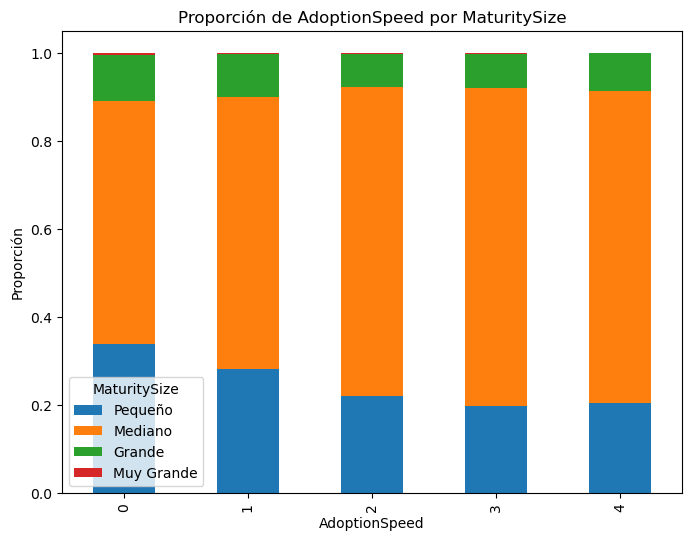

In [111]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='MaturitySize')
plt.title('Distribución de AdoptionSpeed por MaturitySize')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='MaturitySize', labels=['Pequeño', 'Mediano', 'Grande', 'Muy Grande'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_MaturitySize_ct = pd.crosstab(df['AdoptionSpeed'], df['MaturitySize'], normalize='index')
adoption_MaturitySize_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por MaturitySize')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='MaturitySize', labels=['Pequeño', 'Mediano', 'Grande', 'Muy Grande'])  # Ajusta según la codificación real
plt.show()

Estos gráficos exploran cómo la tamaño esperado de madurez (MaturitySize) se relaciona con la velocidad de adopción (AdoptionSpeed), tanto en conteo absoluto como en proporciones. -

- Gráfico 1: Conteo absoluto por MaturitySize
	1.	Mediano domina ampliamente todas las categorías de AdoptionSpeed, representando el mayor grupo de animales.
	2.	Pequeño es el segundo grupo en tamaño, con presencia importante especialmente en adopciones rápidas (0, 1, 2).
	3.	Grande tiene presencia más baja, pero estable.
	4.	Muy Grande es marginal, casi inexistente.

    - La mayoría de los animales son de tamaño mediano. Los pequeños tienen una leve ventaja en adopciones más rápidas.

- Gráfico 2: Proporción por MaturitySize
	1.	Mediano representa entre el 65% y el 75% en todas las categorías, pero su proporción aumenta ligeramente en adopciones lentas.
	2.	Pequeño representa un 20–30%, con ligera caída en las categorías más lentas (3 y 4), indicando adopción más rápida.
	3.	Grande se mantiene relativamente estable.
	4.	Muy Grande es insignificante en proporciones y no influye analíticamente.

    - El tamaño pequeño parece favorecer la adopción temprana, mientras que los medianos y grandes tienden a permanecer más tiempo en espera.

- Conclusión general del análisis de MaturitySize
- Es una variable predictiva potencialmente útil, ya que el tamaño parece influir, aunque de manera leve, en la velocidad de adopción.


## Con `FurLength`

In [112]:
df['FurLength'].value_counts()

FurLength
1    8808
2    5361
3     824
Name: count, dtype: int64

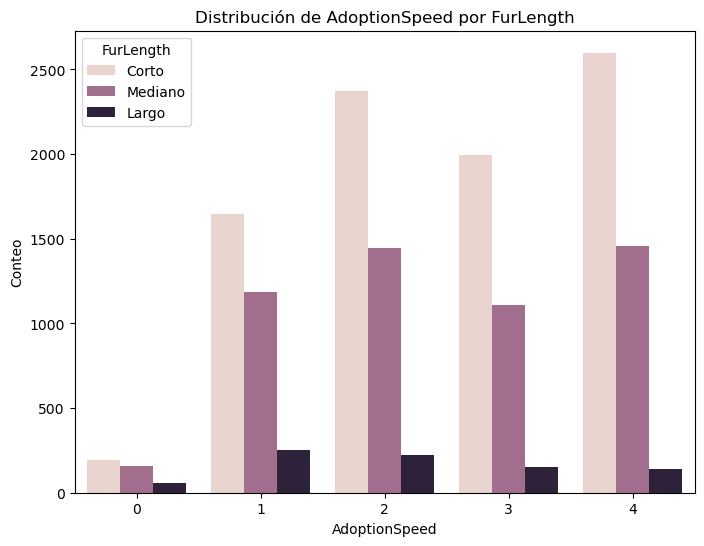

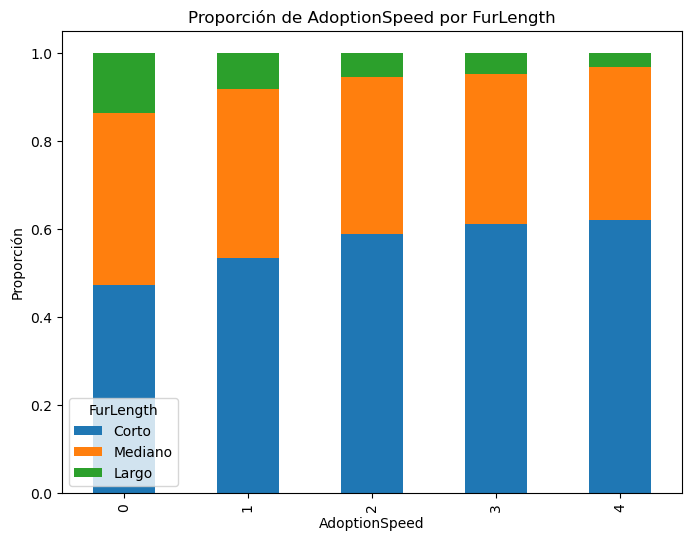

In [113]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='FurLength')
plt.title('Distribución de AdoptionSpeed por FurLength')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='FurLength', labels=['Corto', 'Mediano', 'Largo'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_FurLength_ct = pd.crosstab(df['AdoptionSpeed'], df['FurLength'], normalize='index')
adoption_FurLength_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por FurLength')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='FurLength', labels=['Corto', 'Mediano', 'Largo'])  # Ajusta según la codificación real
plt.show()

#### Consideraciones
Estos gráficos muestran cómo la variable FurLength (longitud del pelaje: corto, mediano, largo) se relaciona con la velocidad de adopción (AdoptionSpeed). 

- Gráfico 1: Distribución absoluta
    - Pelaje corto es el más común en todas las categorías de AdoptionSpeed, especialmente en adopciones lentas (3 y 4).
    - Pelaje mediano también es frecuente, con un patrón similar.
    - Pelaje largo es mucho menos frecuente y sugiere una mayor proporción de adopciones tempranas (valores 0 a 2), aunque su volumen absoluto es bajo.
    - Las mascotas de pelo corto y mediano dominan el dataset. Las de pelo largo parecen tener una ligera ventaja en adopción temprana, aunque hay que tener precaución al interpretar por su bajo número total.

- Gráfico 2: Proporciones por categoría
    - La proporción de pelaje corto aumenta progresivamente desde AdoptionSpeed = 0 hasta 4.
    - El pelaje largo disminuye de forma notable en proporción en las adopciones más lentas.
    - El pelaje mediano se mantiene más estable.
    - Aunque los animales de pelo corto son más comunes, los de pelaje largo tienden a ser adoptados más rápidamente, lo que puede deberse a preferencias estéticas o percepciones de “cuidado especial”.

- Conclusión general del análisis de FurLength
    - Esta variable tiene un potencial valor predictivo, especialmente si se combina con variables como Breed o Type.
    - Las diferencias en longitud de pelo pueden estar reflejando indirectamente tipos de razas o preferencias del adoptante.


## Con `Vaccinated`

In [114]:
df['Vaccinated'].value_counts()

Vaccinated
2    7227
1    5898
3    1868
Name: count, dtype: int64

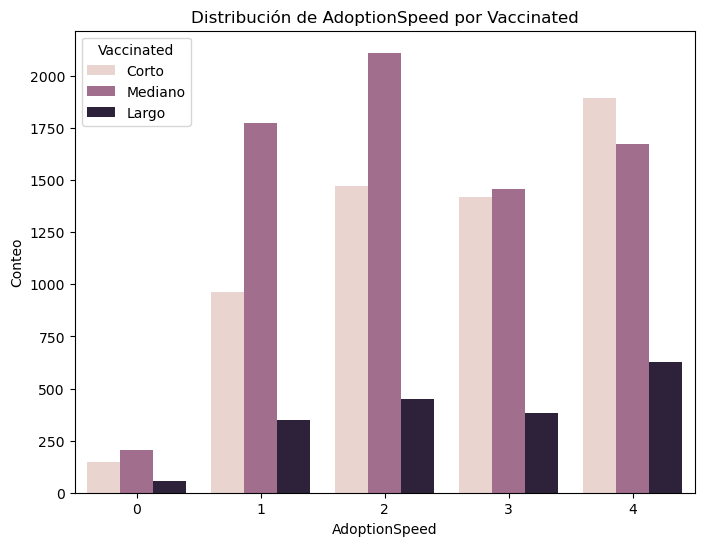

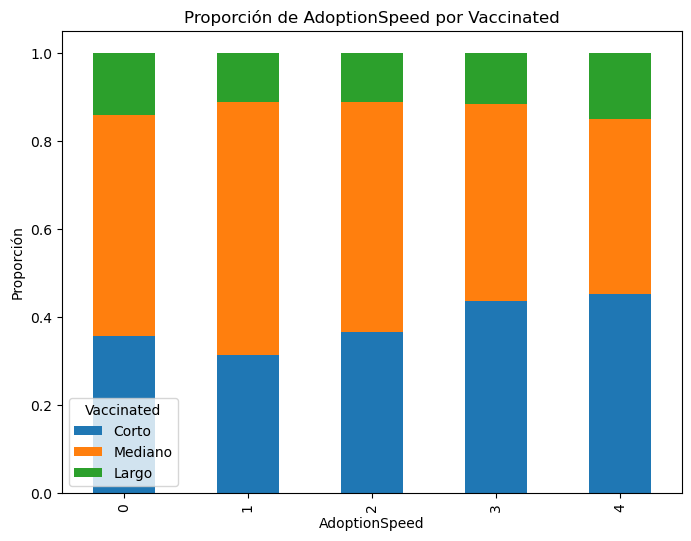

In [115]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='Vaccinated')
plt.title('Distribución de AdoptionSpeed por Vaccinated')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Vaccinated', labels=['Corto', 'Mediano', 'Largo'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_Vaccinated_ct = pd.crosstab(df['AdoptionSpeed'], df['Vaccinated'], normalize='index')
adoption_Vaccinated_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por Vaccinated')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='Vaccinated', labels=['Corto', 'Mediano', 'Largo'])  # Ajusta según la codificación real
plt.show()

#### Consideraciones

Estos gráficos representan cómo se relaciona el estado de vacunación (Vaccinated) con la velocidad de adopción (AdoptionSpeed), tanto en valores absolutos como en proporciones. 

- Gráfico 1: Conteo absoluto
	1.	Las mascotas vacunadas (etiquetadas aquí como “Mediano”) dominan en todas las categorías de AdoptionSpeed, especialmente en las clases 1 a 3.
	2.	Las no vacunadas (probablemente “Corto”) muestran menor volumen, pero aún están representadas significativamente en todos los niveles.
	3.	El grupo “Largo” parece representar casos desconocidos o una tercera categoría, con presencia mucho menor.

    - Hay un mayor número de animales vacunados, y esto se refleja también en todas las velocidades de adopción. Esto puede estar vinculado a políticas de refugios o a que animales vacunados generan más confianza en los adoptantes.

- Gráfico 2: Proporciones por categoría
	1.	La proporción de mascotas vacunadas (Mediano) disminuye levemente en las clases más lentas (3 y 4), mientras que las no vacunadas (Corto) aumentan su proporción.
	2.	El grupo “Largo” (probablemente desconocido o error de codificación) se mantiene estable o apenas aumenta en adopciones lentas.

- Aunque hay vacunados en todos los niveles, las mascotas no vacunadas tienden a tener adopciones más lentas en términos proporcionales.

Conclusión general del análisis de Vaccinated
- El estado de vacunación parece estar moderadamente asociado a una adopción más rápida, lo cual tiene sentido en la práctica (menos riesgo percibido).


## Con `Dewormed`

In [116]:
df['Dewormed'].value_counts()

Dewormed
1    8397
2    4815
3    1781
Name: count, dtype: int64

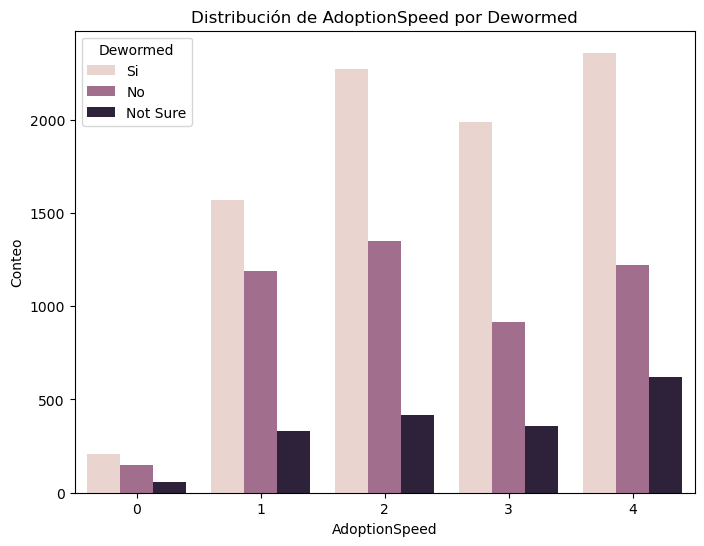

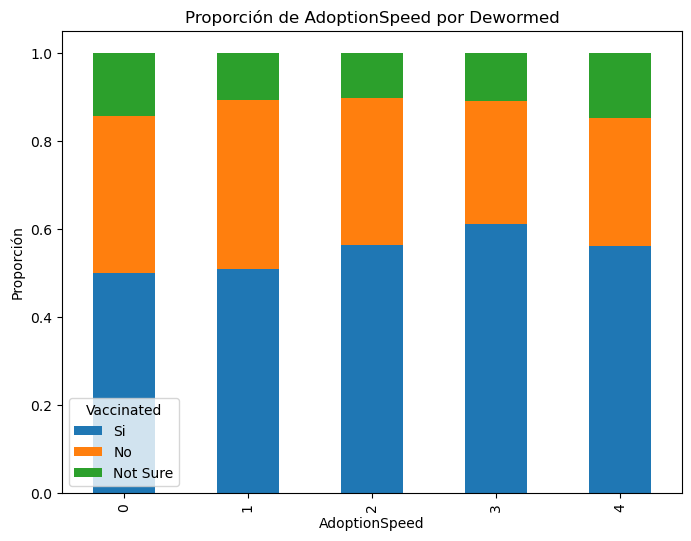

In [117]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='Dewormed')
plt.title('Distribución de AdoptionSpeed por Dewormed')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Dewormed', labels=['Si', 'No', 'Not Sure'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_Dewormed_ct = pd.crosstab(df['AdoptionSpeed'], df['Dewormed'], normalize='index')
adoption_Dewormed_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por Dewormed')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='Vaccinated', labels=['Si', 'No', 'Not Sure'])  # Ajusta según la codificación real
plt.show()

#### Consideraciones

Estos gráficos ilustran la relación entre la desparasitación (Dewormed) de las mascotas y su velocidad de adopción (AdoptionSpeed), mostrando tanto la distribución absoluta como la proporcional. 

- Gráfico 1: Distribución absoluta por Dewormed
    - Las mascotas desparasitadas (etiquetadas como “Sí”) tienen el mayor número de casos en todos los niveles de AdoptionSpeed, destacándose especialmente en las categorías 2, 3 y 4.
	- Las no desparasitadas (“No”) siguen en volumen, pero muestran un patrón similar.
	- El grupo “Not Sure” (desconocido) tiene menor presencia, aunque estable.

    - Las mascotas desparasitadas son mayoría, lo que puede reflejar políticas de refugios. Aunque tienen valores altos en todas las categorías, especialmente en adopciones más lentas, esto puede estar relacionado con su sobre-representación general en el dataset.

- Gráfico 2: Proporción por AdoptionSpeed
	- A medida que AdoptionSpeed aumenta (más lenta la adopción), también aumenta la proporción de mascotas desparasitadas.
	- Las no desparasitadas y desconocidas tienen proporciones más altas en las categorías de adopción más rápida (0, 1, 2).

    - Este patrón puede parecer contraintuitivo, ya que esperaríamos que las mascotas desparasitadas fueran adoptadas más rápido. Sin embargo, puede reflejar:
	- Un sesgo de registro (es más probable que se registre la desparasitación cuando el animal permanece más tiempo).
	- O que otros factores (como salud, edad, raza) estén afectando la adopción más que esta variable sola.

- Conclusión general del análisis de Dewormed
	- A pesar de lo esperable, la desparasitación no parece asociarse directamente a adopción más rápida.
	- Es probable que esta variable sea más útil en combinación con otras variables sanitarias (Vaccinated, Sterilized, Health).
	- El subgrupo “Not Sure” debería tratarse con cuidado: puede imputarse, eliminarse o reagruparse.


## Con `Sterilized`

In [118]:
df['Sterilized'].value_counts()

Sterilized
2    10077
1     3101
3     1815
Name: count, dtype: int64

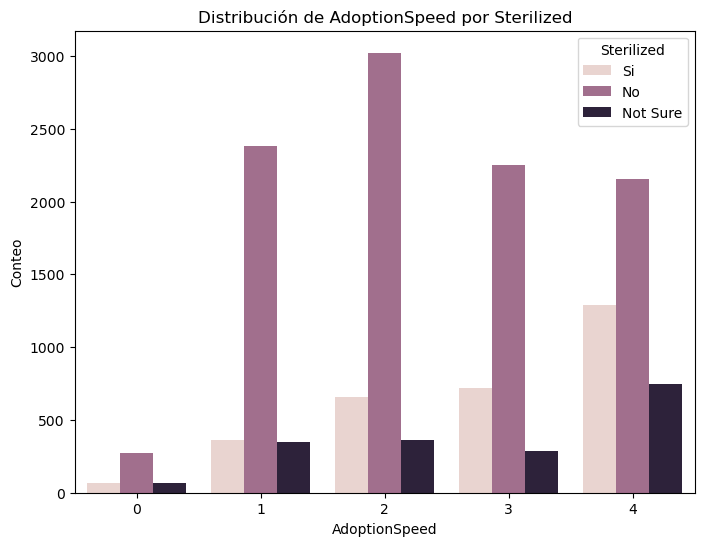

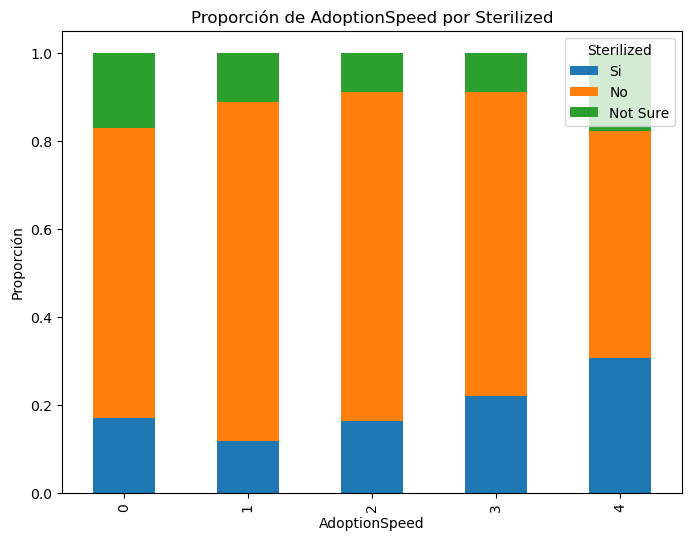

In [119]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='Sterilized')
plt.title('Distribución de AdoptionSpeed por Sterilized')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Sterilized', labels=['Si', 'No', 'Not Sure'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_Sterilized_ct = pd.crosstab(df['AdoptionSpeed'], df['Sterilized'], normalize='index')
adoption_Sterilized_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por Sterilized')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='Sterilized', labels=['Si', 'No', 'Not Sure'])  # Ajusta según la codificación real
plt.show()

#### Consideraciones

Estos gráficos analizan cómo el estado de esterilización (Sterilized) afecta la velocidad de adopción (AdoptionSpeed), tanto en conteos absolutos como en proporciones. 

- Gráfico 1: Conteo absoluto por Sterilized
	- La mayoría de las mascotas no están esterilizadas (“No”), dominando ampliamente todos los valores de AdoptionSpeed.
	- Las esterilizadas (“Sí”) son mucho menos frecuentes, aunque aumentan su conteo hacia las adopciones más lentas.
	- El grupo “Not Sure” tiene menor representación, pero se mantiene en todos los niveles.

    - La mayoría de los animales del dataset no están esterilizados, lo que puede reflejar la realidad del refugio o limitaciones logísticas.

- Gráfico 2: Proporción por Sterilized
	- A pesar del bajo número absoluto, las mascotas esterilizadas ganan proporción en los niveles más lentos de AdoptionSpeed (categoría 4).
	- En adopciones rápidas (0, 1, 2), la proporción de no esterilizados es aún más elevada.

    - Esto sugiere que la esterilización no se asocia con adopciones más rápidas. Incluso, puede estar ocurriendo después de un tiempo en el refugio, lo cual invertiría la relación causa-efecto.

- Conclusión general del análisis de Sterilized
	- Aunque intuitivamente la esterilización debería facilitar la adopción, en este dataset se asocia con mayores tiempos de espera.
	- Puede estar indicando que se esteriliza a los animales luego de estar mucho tiempo en adopción, o que los refugios la priorizan en animales difíciles de adoptar.


## Con `Health`

In [120]:
df['Health'].value_counts()

Health
1    14478
2      481
3       34
Name: count, dtype: int64

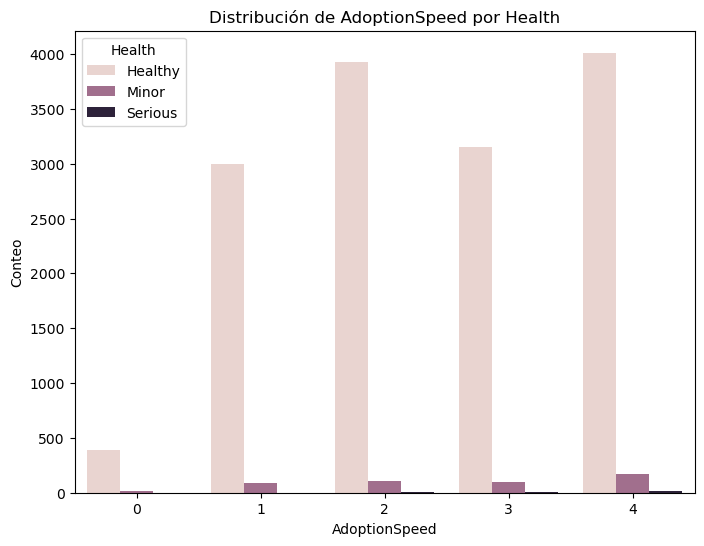

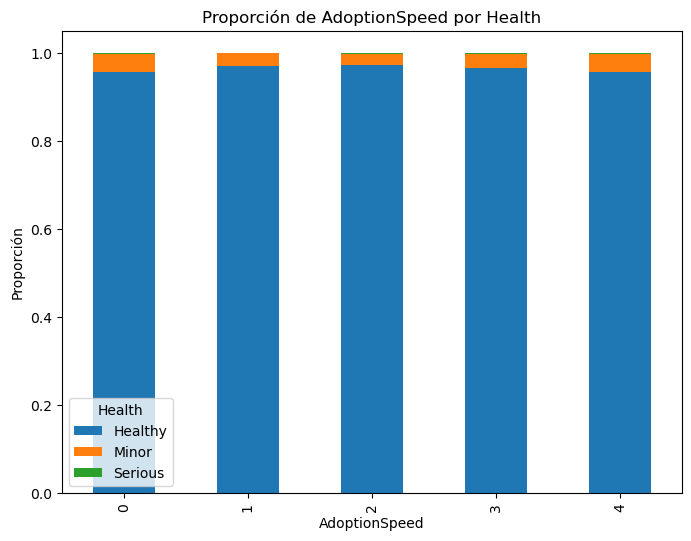

In [121]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='Health')
plt.title('Distribución de AdoptionSpeed por Health')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Health', labels=['Healthy', 'Minor', 'Serious'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_Health_ct = pd.crosstab(df['AdoptionSpeed'], df['Health'], normalize='index')
adoption_Health_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por Health')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='Health', labels=['Healthy', 'Minor', 'Serious'])  # Ajusta según la codificación real
plt.show()

#### Consideraciones

Estos gráficos muestran la relación entre la condición de salud (Health) de las mascotas y la velocidad de adopción (AdoptionSpeed), tanto en valores absolutos como proporcionales. 

- Gráfico 1: Distribución absoluta
	- La inmensa mayoría de los animales están etiquetados como “Healthy” (saludables), lo cual domina todas las clases de AdoptionSpeed.
	- Los casos “Minor” (problemas de salud menores) y “Serious” (problemas graves) son muy pocos en comparación.
	- Aun así, incluso entre animales saludables, hay gran presencia en las categorías más lentas de adopción (3 y 4).

    - La gran mayoría del dataset está en buen estado de salud. Las mascotas con problemas de salud son muy pocas y no se concentran exclusivamente en las adopciones más lentas.

- Gráfico 2: Proporciones por AdoptionSpeed
	- En todas las clases de AdoptionSpeed, el grupo “Healthy” supera el 95%.
	- “Minor” representa una proporción muy pequeña (alrededor del 3–4%) y “Serious” es prácticamente marginal (menos del 1%).

    - No hay una variación proporcional clara en función del estado de salud. Es posible que esta variable tenga poca capacidad discriminativa debido a su fuerte desbalance.

- Conclusión general del análisis de Health
	- Aunque médicamente relevante, esta variable está muy desbalanceada (clase mayoritaria abrumadora).
	- Su capacidad predictiva puede ser limitada salvo que se apliquen técnicas para balanceo o codificación adecuada.
	- Si se decide incluirla, probablemente lo más útil sea transformarla en una variable binaria (saludable vs no saludable).


## Con `Fee` (segmentada)

In [122]:
df['Fee_gratis'] = np.where(df['Fee']==0, 1, 0)
df['Fee_gratis'].value_counts()

Fee_gratis
1    12663
0     2330
Name: count, dtype: int64

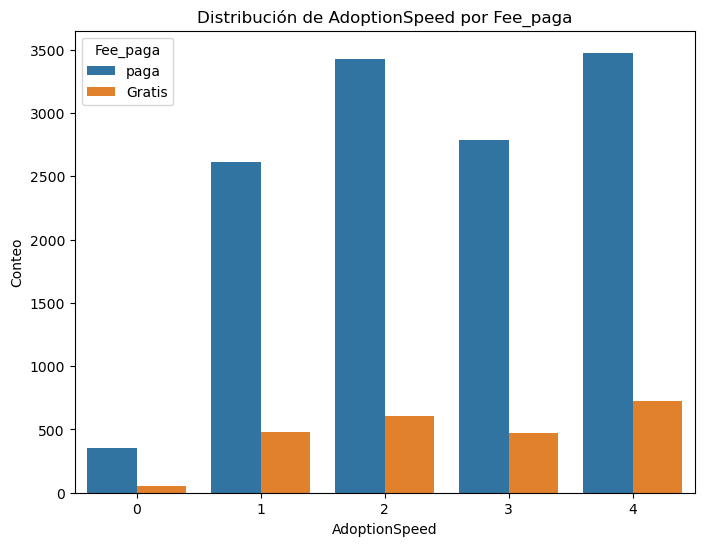

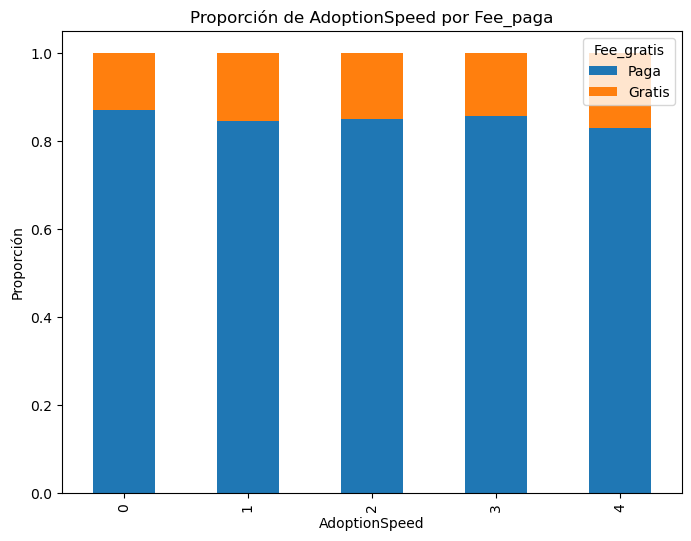

In [123]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='Fee_paga')
plt.title('Distribución de AdoptionSpeed por Fee_paga')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Fee_paga', labels=['paga', 'Gratis'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_Health_ct = pd.crosstab(df['AdoptionSpeed'], df['Fee_paga'], normalize='index')
adoption_Health_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por Fee_paga')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='Fee_gratis', labels=['Paga', 'Gratis'])  # Ajusta según la codificación real
plt.show()

#### Consideraciones

Estos gráficos muestran la relación entre si una mascota fue listada con tarifa de adopción (Fee_paga) o no, y su velocidad de adopción (AdoptionSpeed). 

- Gráfico 1: Distribución absoluta
	- La mayoría de las mascotas son gratuitas (etiquetadas como “Gratis”), y predominan claramente en todos los niveles de AdoptionSpeed, especialmente en las clases más lentas (2, 3, 4).
	- Las mascotas con tarifa (“Paga”) tienen presencia mucho menor, aunque están distribuidas en todos los niveles, con cierta concentración en clases intermedias (1 y 2).

    - La adopción gratuita es ampliamente más frecuente, pero esto puede reflejar un sesgo de entrada (la mayoría son listadas gratis).

- Gráfico 2: Proporciones por AdoptionSpeed
	- La proporción de mascotas gratuitas supera el 85% en todas las categorías.
	- No se observan variaciones proporcionales importantes entre AdoptionSpeed = 0 (adopción inmediata) y 4 (muy lenta).

    - Aunque más comunes, las mascotas gratuitas no parecen tener ventajas proporcionales claras en la velocidad de adopción. Es decir, ser gratis no garantiza adopción más rápida.

- Conclusión general del análisis de Fee_paga
	- La variable está fuertemente desbalanceada hacia “Gratis”.
	- No parece ser un factor determinante en la velocidad de adopción por sí sola.
	- Puede tener valor predictivo combinado con variables como Breed, Health o PhotoAmt, si se interpretara como señal de “valor percibido”.


## Con `Quantity` (segmentada)

In [124]:
df['Quantity_1'] = np.where(df['Quantity']==1, 'Uno', 'Camada')
df['Quantity_1'].value_counts()

Quantity_1
Uno       11565
Camada     3428
Name: count, dtype: int64

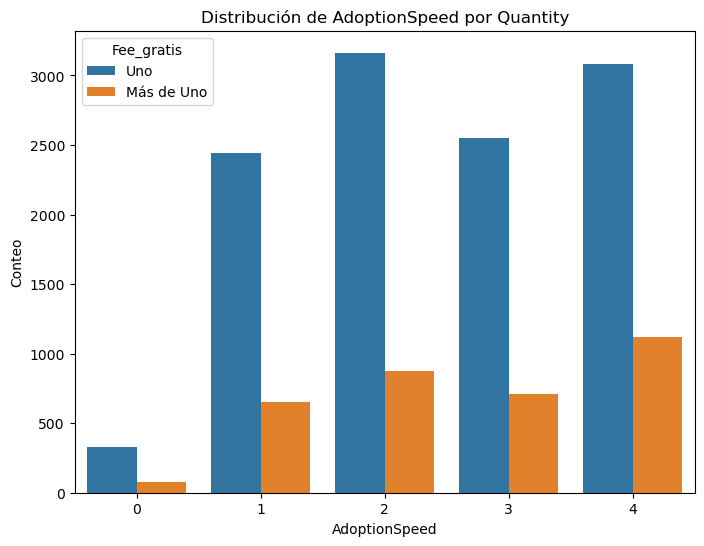

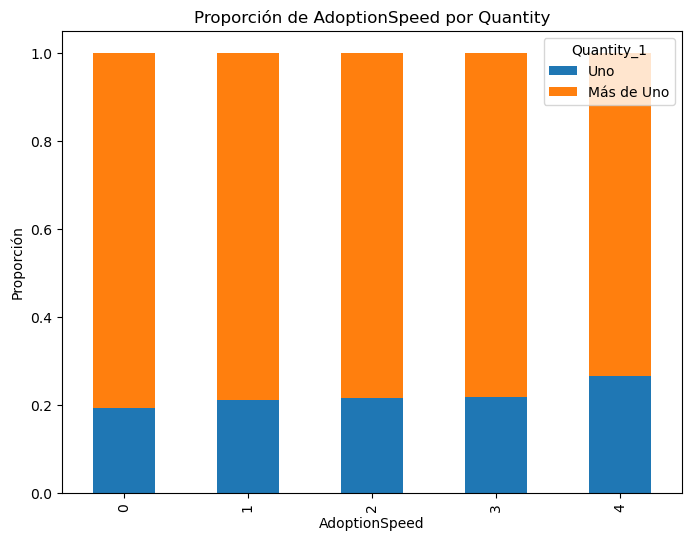

In [125]:
# Gráfico de barras agrupadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='AdoptionSpeed', hue='Quantity_1')
plt.title('Distribución de AdoptionSpeed por Quantity')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Conteo')
plt.legend(title='Fee_gratis', labels=['Uno', 'Más de Uno'])  # Ajusta según la codificación real
plt.show()

# Gráfico de barras de proporciones
adoption_Health_ct = pd.crosstab(df['AdoptionSpeed'], df['Quantity_1'], normalize='index')
adoption_Health_ct.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de AdoptionSpeed por Quantity')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Proporción')
plt.legend(title='Quantity_1', labels=['Uno', 'Más de Uno'])  # Ajusta según la codificación real
plt.show()

#### Consideraciones

Estos gráficos analizan cómo influye la cantidad de mascotas listadas en un mismo anuncio (Quantity) sobre la velocidad de adopción (AdoptionSpeed), considerando si se trata de una sola mascota o más de una.

- Gráfico 1: Conteo absoluto
	- Las publicaciones con una sola mascota son mucho más frecuentes en todos los niveles de AdoptionSpeed.
	- Las publicaciones con más de una mascota están presentes, pero en menor proporción, con distribución más estable en todas las categorías.
	- Se observa que ambas categorías aparecen en los extremos (adopción inmediata y muy lenta), pero los anuncios individuales dominan claramente.

    - Las publicaciones individuales son mayoría, lo que puede reflejar preferencia de refugios o restricciones del sistema.

- Gráfico 2: Proporciones por Quantity
	- Aproximadamente 80% o más de los anuncios son de una sola mascota, con proporciones levemente mayores en adopciones lentas.
	- Las publicaciones múltiples tienen un comportamiento ligeramente más favorable en adopciones rápidas (0 y 1), aunque la diferencia es pequeña.

    - Aunque los anuncios individuales son mayoría, las publicaciones con más de una mascota parecen tener una leve ventaja en adopciones rápidas, lo cual podría explicarse por:
        - Grupos de cachorros o camadas que se adoptan juntos.
        - Sensación de urgencia por parte de adoptantes ante publicaciones de múltiples animales.

- Conclusión general del análisis de Quantity
    - Es una variable interesante porque podría reflejar contextos específicos de adopción (masiva, urgente, accidental).
	- Aporta valor si se la cruza con variables como edad (Age), tipo (Type) o condición de salud.


## Con `PhotoAmt` y `VideoAmt` 

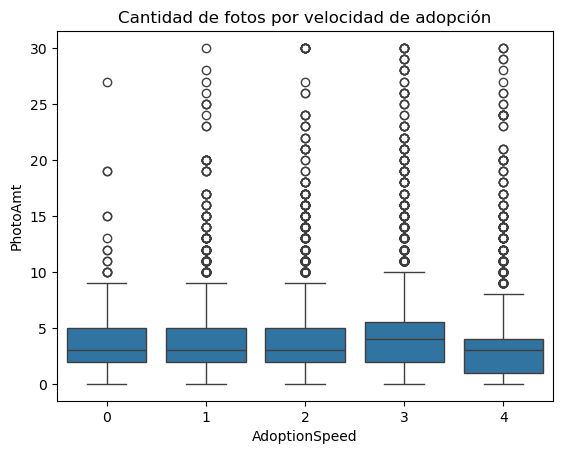

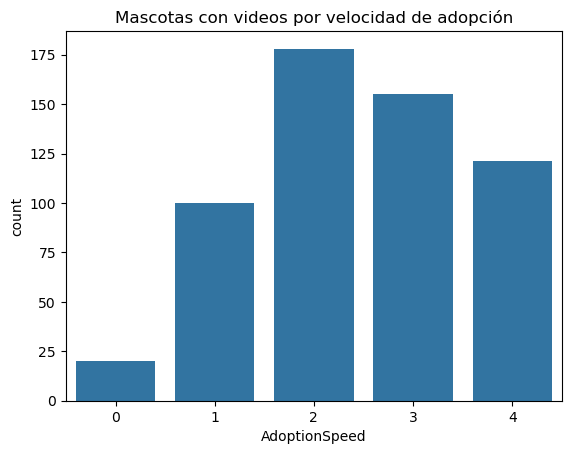

In [126]:
sns.boxplot(data=df, x='AdoptionSpeed', y='PhotoAmt')
plt.title('Cantidad de fotos por velocidad de adopción')
plt.show()

sns.countplot(data=df[df['VideoAmt'] > 0], x='AdoptionSpeed')
plt.title('Mascotas con videos por velocidad de adopción')
plt.show()


#### Consideraciones

Estos gráficos analizan cómo dos variables visuales clave —cantidad de fotos (PhotoAmt) y presencia de videos (VideoAmt)— se relacionan con la velocidad de adopción (AdoptionSpeed). 

- Gráfico 1: Cantidad de fotos por AdoptionSpeed (boxplot)
	- El número de fotos por mascota tiende a estar entre 3 y 5, sin grandes diferencias entre categorías de adopción.
	- Todas las clases presentan outliers con hasta 30 fotos, lo que indica gran variabilidad.
	- La mediana de fotos parece levemente mayor en clases intermedias (2 y 3).

    - No hay una diferencia clara que relacione mayor cantidad de fotos con adopción más rápida, aunque un número muy bajo (0–1 fotos) podría jugar en contra.

- Gráfico 2: Presencia de videos por AdoptionSpeed
	•	Las mascotas con video son más frecuentes en adopciones intermedias (1, 2, 3).
	•	La mayor cantidad se da en AdoptionSpeed = 2.
	•	La presencia cae en 0 (adopción inmediata) y también en 4 (más lenta), lo que podría deberse a extremos menos frecuentes o condiciones distintas.

    - Tener video podría correlacionarse con adopción más eficiente, aunque esto no necesariamente implica causalidad. También puede reflejar mayor esfuerzo del refugio en casos moderados (ni urgentes ni olvidados).

- Conclusión general del análisis visual
	•	Tanto PhotoAmt como VideoAmt son indicadores valiosos del nivel de esfuerzo visual puesto en la publicación.
	•	Incluir estos elementos puede aumentar el interés del adoptante, aunque no garantizan adopción rápida.
	•	Podrían usarse como variables transformadas o categorizadas (por ejemplo: “0 fotos”, “1–4 fotos”, “5+ fotos”; “con video / sin video”).


## Con `VideoAmt` 

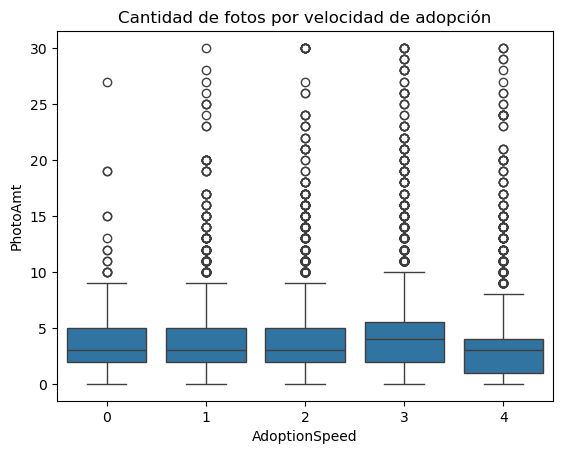

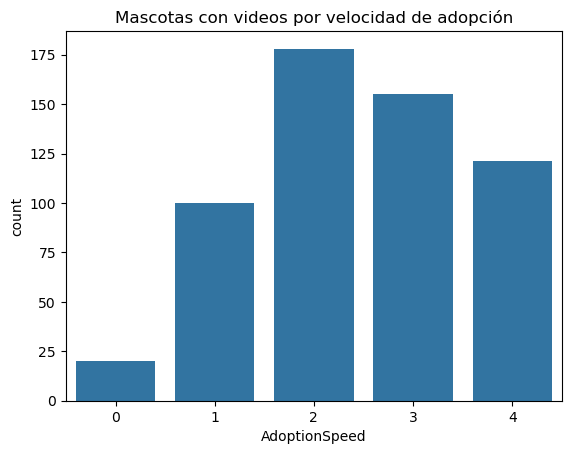

In [127]:
sns.boxplot(data=df, x='AdoptionSpeed', y='PhotoAmt')
plt.title('Cantidad de fotos por velocidad de adopción')
plt.show()

sns.countplot(data=df[df['VideoAmt'] > 0], x='AdoptionSpeed')
plt.title('Mascotas con videos por velocidad de adopción')
plt.show()


## Relación con AdoptionSpeed y Type
### Con `Gender`

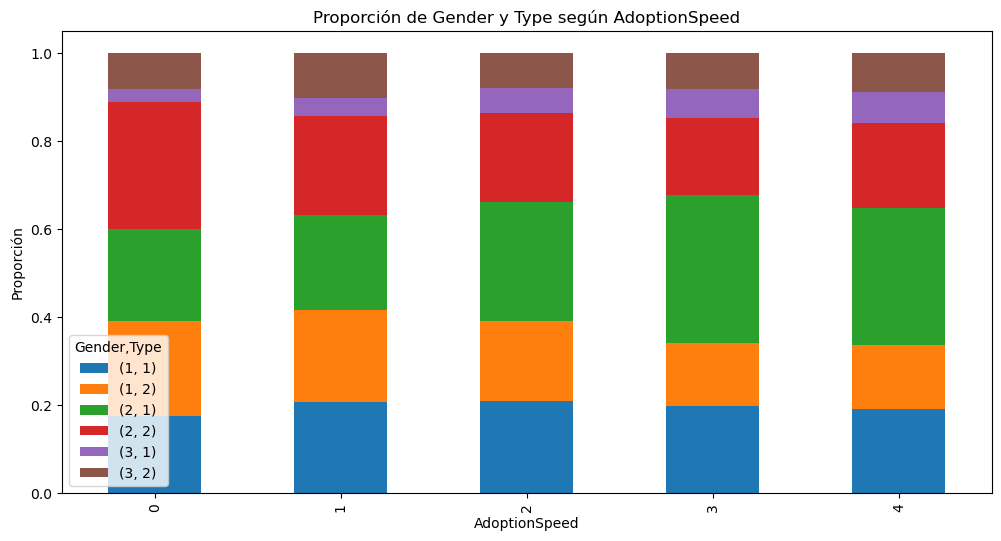

In [128]:
# Crear tabla cruzada con proporciones
tabla = pd.crosstab(index=[df['AdoptionSpeed']], columns=[df['Gender'], df['Type']], normalize='index')
tabla.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Proporción de Gender y Type según AdoptionSpeed')
plt.ylabel('Proporción')
plt.show()

#### Consideraciones

Este gráfico representa la proporción conjunta de Gender y Type (especie) dentro de cada categoría de AdoptionSpeed. Es decir, muestra qué combinación de género y tipo de animal es más frecuente según la velocidad de adopción. 

- Leyenda para interpretar (Gender, Type)
	- Gender:
        1 = Male, 2 = Female, 3 = Other
	- Type:
        1 = Dog, 2 = Cat

- Observaciones clave:
	1.	Perros hembras (2,1) y perros machos (1,1) son los grupos más representativos, especialmente en adopciones intermedias (1, 2, 3).
        - Esto sugiere que los perros, especialmente las hembras, tienen una mayor proporción en adopciones rápidas y moderadas.
	2.	Gatos (Type=2) en general (ya sean machos o hembras) tienen menor proporción en adopciones rápidas (0, 1) y aumentan en adopciones más lentas (3, 4).
        - Esto confirma el patrón observado previamente: los gatos suelen demorar más en ser adoptados.
	3.	El grupo Other (Gender = 3), tanto en perros como en gatos, es muy minoritario, pero su proporción se mantiene estable o incluso levemente creciente en adopciones lentas.

Conclusión:
- Existe un efecto combinado entre género y especie sobre la velocidad de adopción.
- Los perros hembras (2,1) son los más rápidamente adoptados, seguidos por los perros machos (1,1).
- Los gatos, especialmente machos, tienen menor adopción temprana.
- Este tipo de análisis es útil para la generación de variables compuestas (Gender_Type) o para introducir interacciones en modelos predictivos.


### Con `Age`

In [129]:
# Crear categorías de edad en meses
bins = [0, 3, 6, 12, 36, 120]  # bebés, cachorros, jóvenes, adultos, mayores
labels = ['0-3m', '4-6m', '7-12m', '1-3y', '3-10y']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

In [130]:
df['Age_Type'] = df['AgeGroup'].astype(str) + '-' + df['Type'].astype(str)

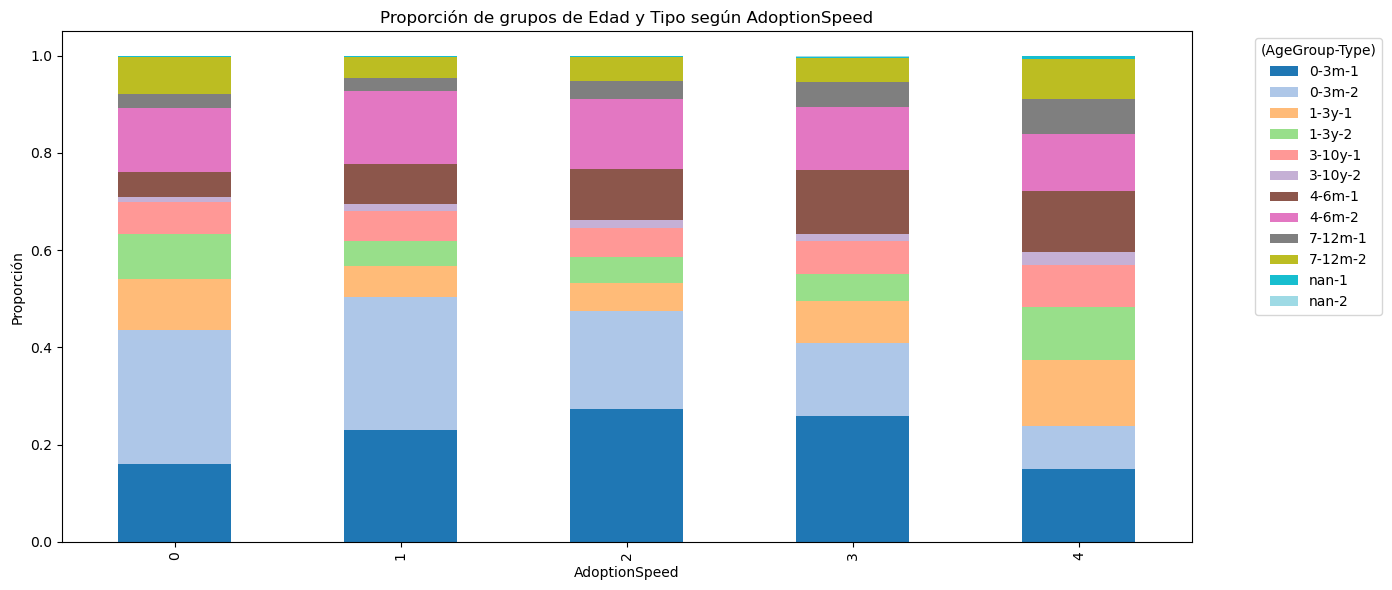

In [131]:
# Tabla cruzada proporcional
tabla_age_type = pd.crosstab(index=df['AdoptionSpeed'], columns=df['Age_Type'], normalize='index')

# Gráfico
tabla_age_type.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title('Proporción de grupos de Edad y Tipo según AdoptionSpeed')
plt.ylabel('Proporción')
plt.xlabel('AdoptionSpeed')
plt.legend(title='(AgeGroup-Type)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Consideraciones

Este gráfico muestra las proporciones combinadas de grupo de edad (AgeGroup) y especie (Type) dentro de cada categoría de velocidad de adopción (AdoptionSpeed). 

- Leyenda (AgeGroup-Type)
	•	Ejemplo: 0-3m-1 = Mascotas de 0 a 3 meses que son perros (Type = 1)
	•	0-3m-2 = Gatos de 0 a 3 meses
	•	3-10y-1 = Perros de 3 a 10 años
	•	nan-1 / nan-2 = edad no disponible para perros/gatos

- Observaciones relevantes:
	1.	Las mascotas más jóvenes (0–3 meses) son más representadas en adopciones rápidas (0 y 1), especialmente:
        - Gatos 0–3m (0-3m-2) son los más frecuentes en AdoptionSpeed = 0, lo cual refuerza la hipótesis de que los gatitos pequeños son muy adoptables.
	2.	Los perros adultos (3–10 años) (3-10y-1) y gatos adultos (3-10y-2) aumentan en adopciones más lentas (3 y 4).
        - Esto indica que las mascotas mayores, en especial los perros grandes, tienen mayores dificultades para ser adoptados rápidamente.
	3.	Mascotas de edad intermedia (4–6 meses y 7–12 meses) se distribuyen relativamente bien en todas las categorías, sin sesgo claro.
	4.	Perros jóvenes (0–3m y 4–6m) tienen representación creciente en AdoptionSpeed = 2 y 3, lo que sugiere que no siempre son adoptados tan rápido como los gatos de la misma edad.

- Conclusión final del cruce AgeGroup × Type × AdoptionSpeed
	- La edad es uno de los factores más influyentes en la velocidad de adopción.
	- Gatitos pequeños (<3 meses) tienen alta adopción inmediata.
	- Mascotas adultas (3–10 años), especialmente perros, enfrentan mayores demoras.
	- La especie modula el efecto de la edad: los gatos pequeños superan en velocidad a los perros pequeños.



### Con `Color`

In [132]:
df.color_n.value_counts().sort_index(ascending = True)

color_n
1    4471
2    6133
3    4389
Name: count, dtype: int64

In [133]:
# Suponiendo que Color1, Color2 y Color3 son numéricos y 0 representa 'sin color'
df['color_n'] = 1  # por defecto monocromo

df.loc[(df['Color2'] != 0) & (df['Color3'] == 0), 'color_n'] = 2  # bicolor
df.loc[(df['Color2'] != 0) & (df['Color3'] != 0), 'color_n'] = 3  # tricolor

# Mapear a etiquetas
df['color_tipo'] = df['color_n'].map({1: 'Monocromo', 2: 'Bicolor', 3: 'Tricolor'})

<Figure size 1000x600 with 0 Axes>

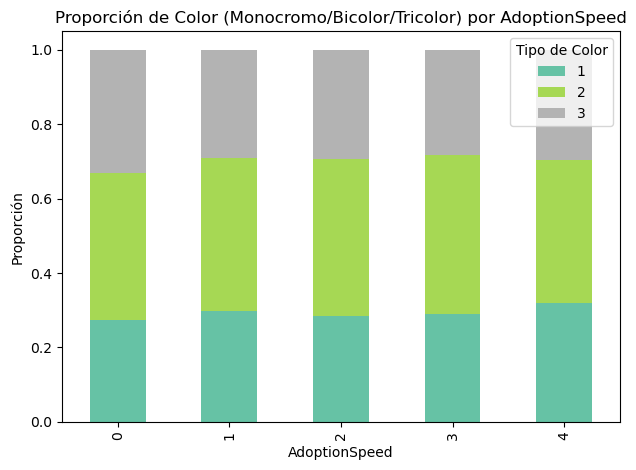

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Proporción por tipo de color y AdoptionSpeed
color_prop = pd.crosstab(index=df['AdoptionSpeed'], columns=df['color_n'], normalize='index')

plt.figure(figsize=(10, 6))
color_prop.plot(kind='bar', stacked=True, colormap='Set2')
plt.title('Proporción de Color (Monocromo/Bicolor/Tricolor) por AdoptionSpeed')
plt.ylabel('Proporción')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Tipo de Color')
plt.tight_layout()
plt.show();

#### Consideraciones

Este gráfico muestra cómo se distribuyen los tipos de color (monocromo, bicolor, tricolor) en función de la velocidad de adopción (AdoptionSpeed). 

- Observaciones clave
	1.	Bicolores (2) son el grupo más representado en todos los niveles de AdoptionSpeed, especialmente entre los valores intermedios (1, 2, 3).
	- Interpretación: El bicolor es el patrón más común y mantiene una distribución estable, lo cual puede reflejar tanto disponibilidad como una estética preferida por adoptantes.
	2.	Tricolores (3) no muestran una ventaja clara en adopciones rápidas (0, 1), y su proporción incluso cae levemente en AdoptionSpeed = 1 y 2.
	- Interpretación: A pesar de que los tricolores podrían parecer más llamativos, no parecen adoptarse más rápido.
	3.	Monocromos (1) tienen una proporción más baja en todos los niveles, pero ligeramente más alta en adopciones lentas (4).
	- Interpretación: Las mascotas de un solo color podrían percibirse como menos atractivas, afectando la velocidad de adopción.

- Conclusión general
	•	Aunque el color parece influir en la percepción, no se observan diferencias extremas.
	•	Bicolores son los más comunes y estables.
	•	Monocromos podrían estar levemente desventajados.
	•	Esta variable puede aportar información adicional cuando se combina con otras variables como edad, raza o tamaño.


### Con `Breed1`y `Breed2`

In [135]:
df['MixedBreed'] = (df['Breed2'] != 0).astype(int)  # 0 = pura, 1 = mezcla

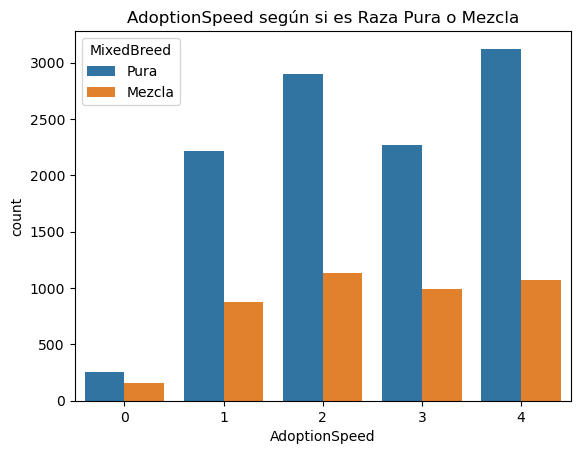

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='AdoptionSpeed', hue='MixedBreed', data=df)
plt.title('AdoptionSpeed según si es Raza Pura o Mezcla')
plt.legend(title='MixedBreed', labels=['Pura', 'Mezcla'])
plt.show()

In [144]:
breed_cross = pd.crosstab(df['Breed1'], df['Breed2'])

print(breed_cross.head(10))

Breed2  0    1    2    4    5    10   14   16   17   18   ...  296  299  300  \
Breed1                                                    ...                  
0         0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1         2    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3         1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
5         1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
7         1    0    0    0    0    0    0    0    0    0  ...    0    0    0   
10        2    0    0    0    0    0    0    0    0    0  ...    0    0    0   
11        2    0    0    0    0    0    0    0    0    0  ...    0    0    0   
15        2    0    0    0    0    0    0    0    0    0  ...    0    0    0   
16        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
17        4    0    0    0    0    0    0    0    0    0  ...    0    0    0   

Breed2  301  302  303  304  305  306  3

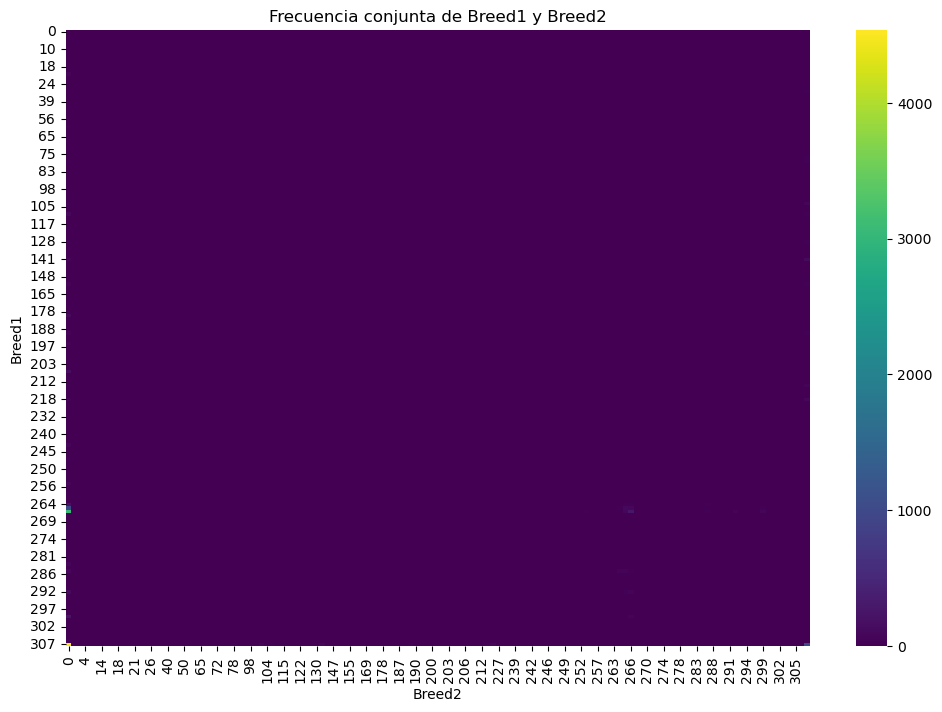

In [138]:
plt.figure(figsize=(12, 8))
sns.heatmap(breed_cross, cmap='viridis', cbar=True)
plt.title('Frecuencia conjunta de Breed1 y Breed2')
plt.xlabel('Breed2')
plt.ylabel('Breed1')
plt.show()

In [142]:
top_mix = df[df['MixedBreed'] == 1].groupby(['BreedName1', 'BreedName2']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)

print(df.columns)

print(breed_cross.columns)

Index([        'Type',         'Name',          'Age',       'Breed1',
             'Breed2',       'Gender',       'Color1',       'Color2',
             'Color3', 'MaturitySize',
       ...
                  296,            299,            300,            301,
                  302,            303,            304,            305,
                  306,            307],
      dtype='object', length=180)
Index([  0,   1,   2,   4,   5,  10,  14,  16,  17,  18,
       ...
       296, 299, 300, 301, 302, 303, 304, 305, 306, 307],
      dtype='int64', name='Breed2', length=135)


In [140]:
df = df.merge(breed_cross.rename(columns={'BreedID': 'Breed1', 'BreedName': 'BreedName1'}), on='Breed1', how='left')
df = df.merge(breed_cross.rename(columns={'BreedID': 'Breed2', 'BreedName': 'BreedName2'}), on='Breed2', how='left')

KeyError: 'Breed2'

In [158]:
# Cargar el archivo BreedLabels.csv
BreedLabels = pd.read_csv('../input/petfinder-adoption-prediction/BreedLabels.csv')

print(BreedLabels.head())

# Merge para agregar el nombre de la raza 1
df = df.merge(
    BreedLabels.rename(columns={'BreedID': 'Breed1', 'BreedName': 'BreedName1'}),
    on='Breed1',
    how='left'
)

# Merge para agregar el nombre de la raza 2
df = df.merge(
    BreedLabels.rename(columns={'BreedID': 'Breed2', 'BreedName': 'BreedName2'}),
    on='Breed2',
    how='left'
)

print(df)


   BreedID  Type         BreedName
0        1     1     Affenpinscher
1        2     1      Afghan Hound
2        3     1  Airedale Terrier
3        4     1            Akbash
4        5     1             Akita


MergeError: Passing 'suffixes' which cause duplicate columns {'Type_x'} is not allowed.

In [ ]:
top_mix

In [ ]:
top_breeds = df['BreedName1'].value_counts().head(10).index.tolist()
df_top = df[df['BreedName1'].isin(top_breeds)]

###### Análisis multivariado

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.countplot(x='AdoptionSpeed', hue='BreedName1', data=df_top[df_top['Type'] == 1])
plt.title('Distribución de AdoptionSpeed por Raza (Perros)')
plt.legend(title='Raza principal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(x='AdoptionSpeed', hue='BreedName1', data=df_top[df_top['Type'] == 2])
plt.title('Distribución de AdoptionSpeed por Raza (Gatos)')
plt.legend(title='Raza principal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
tabla = pd.crosstab(index=[df_top['AdoptionSpeed']], columns=[df_top['BreedName1'], df_top['Type']], normalize='index')
tabla.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title('Proporción conjunta de Raza principal y Tipo por AdoptionSpeed')
plt.ylabel('Proporción')
plt.tight_layout()
plt.show()

Análisis cruzado de Breed1 × AdoptionSpeed × Type, agrupando perros y gatos por raza:

- Gráfico 1: Perros (Type = 1)
	- Mixed Breed domina ampliamente todas las categorías de AdoptionSpeed, en especial las más lentas (3 y 4).
	- Razas como Shih Tzu, Poodle y Labrador Retriever tienen presencia moderada y una leve inclinación hacia adopciones más rápidas (1, 2).
	- Interpretación: Los perros de raza reconocible tienden a tener adopciones algo más rápidas que los de raza mixta.

- Gráfico 2: Gatos (Type = 2)
	- Domestic Short Hair es la raza más dominante, especialmente en adopciones lentas (3, 4).
	- Domestic Medium Hair y Long Hair siguen en frecuencia, con un comportamiento bastante parejo.
	- Razas como Persian y Siamese tienen menor representación, pero tienden a concentrarse más en adopciones tempranas.

- En gatos también se ve que las razas más comunes tienen mayor volumen y adopciones más lentas, mientras que razas más “especiales” parecen tener adopciones más eficientes.

- Gráfico 3: Proporción conjunta (BreedName1 × Type) por AdoptionSpeed
	- Aquí se confirma que:
	- Mixed Breed, Domestic Short Hair y Medium Hair ocupan gran parte de los registros.
	- Razas como Shih Tzu, Poodle y Persian representan una fracción pequeña, pero se concentran más en adopciones rápidas (0, 1).
	- Esto sugiere una posible preferencia del adoptante por razas más definidas o estéticas.

- Conclusión general
	•	La raza principal (Breed1) y el tipo (Type) influyen claramente en la velocidad de adopción.
	•	Razas mixtas y comunes tienden a permanecer más tiempo en adopción.
	•	Razas pequeñas y reconocidas (en perros) o exóticas (en gatos) parecen tener adopciones más rápidas.


### Con `MaturitySize`

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='MaturitySize_df', data=df[df['Type'] == 1])
plt.title('AdoptionSpeed por MaturitySize (Perros)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Tamaño')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='MaturitySize_df', data=df[df['Type'] == 2])
plt.title('AdoptionSpeed por MaturitySize (Gatos)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Tamaño')
plt.show()

#### Consideraciones

Interpretación cruzada de MaturitySize × AdoptionSpeed × Type usando los dos gráficos realizados:

- Gráfico 1: Perros (Type = 1)
    - Distribución de MaturitySize por AdoptionSpeed:
        - Tamaño mediano domina ampliamente todos los niveles de velocidad de adopción.
        - Los perros pequeños tienen una presencia moderada, y tienden a concentrarse más en adopciones rápidas (1, 2).
        - Los perros grandes y muy grandes aparecen poco, pero con más frecuencia en adopciones lentas (3, 4).

    - Interpretación:
        - El tamaño mediano es el más común, pero los perros pequeños tienen una ligera ventaja en adopción rápida.
        - Tamaños grandes parecen penalizados, especialmente si no están esterilizados o son adultos.
        - Los muy grandes casi no se adoptan rápido, posiblemente por necesidades de espacio o alimentación.

- Gráfico 2: Gatos (Type = 2)
    - Distribución de MaturitySize por AdoptionSpeed:
        - Casi todos los gatos son medianos o pequeños.
        - Gatos medianos son mayoría en todas las clases de AdoptionSpeed, incluyendo las más rápidas y más lentas.
        - Gatos pequeños muestran una ligera ventaja en adopciones rápidas (0, 1, 2).
        - Gatos grandes y muy grandes existen, pero son raros y no tienen un patrón claro.
    - Interpretación:
        - En gatos, el tamaño tiene menor peso discriminativo que en perros, ya que hay menor variabilidad natural.
        - Los gatos pequeños tienden a tener adopciones más rápidas, aunque la diferencia no es drástica.

- Conclusión general del cruce MaturitySize × AdoptionSpeed × Type:
	- El tamaño corporal influye más en perros que en gatos.
	- Perros pequeños y medianos tienen adopciones más rápidas; los grandes y muy grandes enfrentan barreras.
	- En gatos, el efecto del tamaño es leve, pero se mantiene la preferencia leve por los más pequeños.


### Con `FurLength`

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='FurLength_df', data=df[df['Type'] == 1])
plt.title('AdoptionSpeed por FurLength (Perros)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Pelaje')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='FurLength_df', data=df[df['Type'] == 2])
plt.title('AdoptionSpeed por FurLength (Gatos)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Pelaje')
plt.tight_layout()
plt.show()

#### Consideraciones

Análisis del cruce entre FurLength × AdoptionSpeed × Type.

- Gráfico 1: Perros (Type = 1)
    - Distribución de FurLength por velocidad de adopción:
        - Los perros de pelaje corto son los más frecuentes en todos los niveles de AdoptionSpeed, con especial presencia en clases lentas (3, 4).
        - Los de pelaje mediano tienen también alta frecuencia, y están algo más presentes en adopciones más rápidas (1, 2).
        - Los perros de pelaje largo son escasos, pero su presencia es relativamente constante.

    - Interpretación:
        - El pelaje corto es dominante entre los perros, pero eso no implica adopción más rápida.
        - Los de pelaje mediano parecen adoptarse ligeramente más rápido.
        - El pelaje largo no muestra ventaja ni desventaja clara, aunque su bajo número limita las conclusiones.

- Gráfico 2: Gatos (Type = 2)
    - Distribución de FurLength por velocidad de adopción:
        - En gatos, los de pelaje corto dominan ampliamente, especialmente en adopciones rápidas (1, 2) y lentas (4).
        - Pelaje mediano tiene también alta presencia, pero parece más representado en clases intermedias (2, 3).
        - Los de pelaje largo son pocos, pero están más presentes en AdoptionSpeed = 1, lo que sugiere una posible preferencia estética.
    - Interpretación:
        - Gatos de pelaje corto se adoptan más y más rápido.
        - Pelaje largo podría tener una ventaja estética, aunque con bajo volumen.

- Conclusión general de FurLength × AdoptionSpeed × Type:
	- El largo del pelaje sí influye, pero de forma diferenciada entre perros y gatos.
	- En perros, el pelaje mediano podría ser más favorable.
	- En gatos, los de pelaje corto predominan, pero los de pelaje largo podrían ser adoptados más rápido si están bien fotografiados o cuidados.
	- El pelaje es una variable que podría reflejar estética o facilidad de cuidado (menos cepillado = más adopción).


### Con `Vaccinated`

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='Vaccinated', data=df[df['Type'] == 1])
plt.title('AdoptionSpeed por Vaccinated (Perros)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Vaccinated')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='Vaccinated', data=df[df['Type'] == 2])
plt.title('AdoptionSpeed por Vaccinated (Gatos)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Vaccinated')
plt.tight_layout()
plt.show()

#### Consideraciones

Análisis de Vaccinated × AdoptionSpeed × Type.

⸻

✅ Recordatorio de codificación usual:

- Valor	Significado
    - 1	Sí (Vacunado)
    - 2	No vacunado
    - 3	No estoy seguro


- Gráfico 1: Perros
    - Distribución de vacunación por velocidad de adopción:
        - Vacunados (1) son mayoría en todos los niveles de AdoptionSpeed, especialmente en clases intermedias y lentas.
        - No vacunados (2) tienen presencia considerable, también más marcada en 1 y 2.
        - “Not sure” (3) son el grupo menor, aunque se mantienen estables en todos los niveles, incluso en 4.

    - Interpretación:
        - Vacunar no garantiza adopción rápida, pero sí está fuertemente asociado a los casos disponibles.
        - Los adoptantes pueden valorar la vacunación, pero es probable que se relacione con refugios más organizados que gestionan adopciones más tardías.
        - El grupo “no estoy seguro” sugiere falta de control sanitario previo o animales callejeros.

- Gráfico 2: Gatos
    - Distribución de vacunación por AdoptionSpeed:
        - No vacunados (2) dominan absolutamente todos los niveles de AdoptionSpeed, incluso los más rápidos.
        - Vacunados (1) son claramente minoría y parecen concentrarse más en adopciones más lentas.
        - “Not sure” (3) se comporta similar al caso de perros, con frecuencia baja y estable.

    - Interpretación:
        - En gatos, la mayoría se entrega sin vacunas, lo que puede reflejar situaciones de rescate, gatos comunitarios o adopciones informales.
        - Contrario al sentido común, la vacunación no está relacionada con adopción más rápida, posiblemente por estar vinculada a refugios que esperan para vacunar.

- Conclusión general del cruce Vaccinated × AdoptionSpeed × Type:
	- La vacunación no es un predictor directo de adopción rápida, y su efecto es distinto entre perros y gatos.
	- En perros, estar vacunado es lo más común, pero no acelera la adopción.
	- En gatos, la vacunación es menos frecuente, y los no vacunados se adoptan igual o incluso más rápido.
	- El campo Vaccinated podría funcionar más como indicador de nivel de formalidad o cuidado previo, que como determinante del deseo de adopción.


### Con `Dewormed`

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='Dewormed', data=df[df['Type'] == 1])
plt.title('AdoptionSpeed por Dewormed (Perros)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Dewormed')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='Dewormed', data=df[df['Type'] == 2])
plt.title('AdoptionSpeed por Dewormed (Gatos)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Dewormed')
plt.tight_layout()
plt.show()

#### Consideraciones

Análisis de Dewormed × AdoptionSpeed × Type.

⸻

✅ Recordatorio de codificación habitual en Dewormed:

|Valor|	Significado|
|-----|------------|
|1    |Sí, desparasitado|
|2	|No desparasitado|
|3	|No estoy seguro|



- Gráfico 1: Perros
    - Distribución por velocidad de adopción:
        - Los perros desparasitados (1) son mayoría en todos los niveles de AdoptionSpeed.
        - Los no desparasitados (2) y los “no seguros” (3) tienen menor representación, pero son visibles en todas las categorías.
        - Incluso en adopciones rápidas (0, 1, 2), hay una buena proporción de no tratados.

    - Interpretación:
        - La desparasitación está presente en la mayoría de los casos, lo que indica un buen nivel de cuidado previo.
        - No obstante, no parece condicionar fuertemente la adopción rápida, aunque podría ayudar a generar confianza en refugios o campañas.

- Gráfico 2: Gatos
    - Distribución por velocidad de adopción:
	- La situación se vuelve más pareja entre desparasitados (1) y no desparasitados (2).
	- A diferencia de los perros, los gatos no desparasitados se adoptan tan rápidamente como los que sí lo están.
	- El grupo “no estoy seguro” (3) es más reducido pero constante.

    - Interpretación:
	- La desparasitación en gatos no parece impactar significativamente la adopción rápida.
	- Puede reflejar una menor intervención veterinaria previa o situaciones más informales de rescate.

-  Conclusión general del cruce Dewormed × AdoptionSpeed × Type:
	- En perros, la desparasitación está más extendida, pero no garantiza adopción rápida.
	- En gatos, la desparasitación no es determinante y muchos se adoptan sin tratamiento.
	- Este campo puede servir como indicador de atención previa o nivel de formalidad, más que como predictor directo de velocidad de adopción.



### Con `Sterilized`

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='Sterilized', data=df[df['Type'] == 1])
plt.title('AdoptionSpeed por Sterilized (Perros)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Sterilized')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='Sterilized', data=df[df['Type'] == 2])
plt.title('AdoptionSpeed por Sterilized (Gatos)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Sterilized')
plt.tight_layout()
plt.show()

#### Conclusiones

Análisis Sterilized × AdoptionSpeed × Type.

- Recordatorio de codificación:

|Valor	|Significado |
|-------|------------|
|1	|Esterilizado (Sí) |
|2	|No esterilizado |
|3	|No estoy seguro |


- Gráfico 1: Perros
    - Distribución por AdoptionSpeed:
        - No esterilizados (2) dominan ampliamente en todos los niveles, incluso en las adopciones más rápidas (1, 2).
        - Esterilizados (1) aumentan progresivamente hacia las clases más lentas, especialmente en 4.
        - El grupo “Not sure” (3) es consistente pero más pequeño.

    - Interpretación:
        - La mayoría de los perros disponibles no están esterilizados, y eso no parece afectar negativamente la adopción rápida.
        - De hecho, los perros esterilizados se adoptan más lentamente, posiblemente porque requieren un proceso previo adicional (gestión, cirugía, recuperación).
        - El campo puede reflejar el momento en que se publica el aviso, no necesariamente la condición al momento de la adopción.

- Gráfico 2: Gatos
        - Distribución por AdoptionSpeed:
        - Mismo patrón que en perros: los no esterilizados (2) dominan por completo, incluso en adopciones rápidas (0, 1, 2).
        - Los esterilizados (1) tienen su punto más alto recién en las clases lentas (3, 4).
        - “No estoy seguro” (3) es bajo, pero constante.

    - Interpretación:
        - En gatos, la esterilización tampoco se relaciona con adopción más rápida.
        - Podría reflejar situaciones más informales, de calle, o bien que la esterilización se realiza después de publicado el aviso o como condición post-adopción.

- Conclusión general del cruce Sterilized × AdoptionSpeed × Type:
	- La esterilización no acelera la adopción ni en perros ni en gatos, y muchas mascotas se publican sin haber sido intervenidas aún.
	- De hecho, las esterilizadas parecen concentrarse más en adopciones tardías, lo cual sugiere que este campo refleja más el proceso institucional del refugio que el deseo del adoptante.
	- El campo es útil para entender prácticas de rescate y profesionalismo, más que como predictor de comportamiento del adoptante.



### Con `Health`

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='Health', data=df[df['Type'] == 1])
plt.title('AdoptionSpeed por Health (Perros)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Health')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', hue='Health', data=df[df['Type'] == 2])
plt.title('AdoptionSpeed por Health (Gatos)')
plt.ylabel('Cantidad')
plt.xlabel('AdoptionSpeed')
plt.legend(title='Health')
plt.tight_layout()
plt.show()

#### Conclusiones

Análisis: Health × AdoptionSpeed × Type:

- Codificación habitual de Health:

|Valor	|Significado |
|-------|------------|
|1	|Saludable |
|2	|Enfermedad menor |
|3	|Enfermedad grave |


- Gráfico 1: Perros 
    - Distribución por AdoptionSpeed:
        - La gran mayoría de los perros están clasificados como saludables (1).
        - Muy pocos tienen enfermedad menor (2), y menos aún enfermedad grave (3).
        - Aun así, todos los niveles de salud están presentes en todas las velocidades de adopción, aunque los no saludables tienden a concentrarse en las clases más lentas.

    - Interpretación:
        - Los perros sanos dominan ampliamente y se reparten de manera pareja en AdoptionSpeed.
        - Los enfermos tienden a demorarse más en ser adoptados, pero igual logran adopción.
        - El campo puede reflejar condición al momento de publicación, no necesariamente situación irreversible.

- Gráfico 2: Gatos
    - Distribución por AdoptionSpeed:
        - Aún más marcado que en perros: casi todos los gatos están registrados como saludables (1).
        - Las enfermedades menores (2) son escasas, y las graves (3) son casi inexistentes.
        - A diferencia de perros, la salud parece no influir en la velocidad de adopción en gatos.

    - Interpretación:
        - Puede haber subregistro de condiciones clínicas, o bien los gatos en malas condiciones no llegan a publicarse.
        - En este caso, el campo tiene muy bajo poder discriminativo.

- Conclusión general del cruce Health × AdoptionSpeed × Type:
	- La variable Health tiene baja variabilidad, con la mayoría de las mascotas registradas como saludables.
	- En perros, la presencia de enfermedades puede retrasar la adopción, pero no impedirla.
	- En gatos, la falta de casos no permite extraer inferencias sólidas.
	- El campo es útil como verificación de calidad de los datos, pero no es determinante en la adopción (al menos en los registros disponibles).


### Con `Quantity`

In [ ]:
df['Quantity_1'].value_counts()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df[df['Type'] == 1], x='AdoptionSpeed', hue='Quantity_1')
plt.title('Distribución de Quantity por AdoptionSpeed (Perros)')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Cantidad')
plt.legend(title='Cantidad en la publicación')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df[df['Type'] == 2], x='AdoptionSpeed', hue='Quantity_1')
plt.title('Distribución de Quantity por AdoptionSpeed (Gatos)')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Cantidad')
plt.legend(title='Cantidad en la publicación')
plt.tight_layout()
plt.show()

#### Conclusiones
Análisis de Quantity × AdoptionSpeed × Type. Este cruce nos permite entender si la cantidad de mascotas publicadas en una misma entrada influye en la velocidad de adopción, diferenciando entre perros y gatos.

- Perros
    - La gran mayoría de las publicaciones de perros son individuales (“Uno”), en todas las clases de AdoptionSpeed.
    - Las publicaciones de “Camada” (Quantity > 1) representan una porción menor, pero crecen progresivamente hacia AdoptionSpeed = 4 (adopción más lenta).
    - En adopciones rápidas (0, 1), las camadas son muy poco frecuentes.

    - Interpretación:
        - Los perros publicados de a uno se adoptan más rápidamente, lo que puede reflejar:
        - Preferencia del adoptante por elegir una sola mascota.
        - Mayor facilidad logística (menos compromiso, menos dudas).
        - Las camadas tienden a adoptarse más lentamente, lo cual podría deberse a:
        - Mayor dificultad para encontrar adoptantes múltiples.
        - Percepción de más trabajo, necesidad de cuidados simultáneos.
        - Posibilidad de que algunos hermanos queden sin adoptar.

- Gatos
    - Las publicaciones de gatos individuales también son mayoría, pero las camadas tienen una representación mayor que en perros.
    - En adopciones rápidas (1, 2), las camadas están más presentes que en el caso de los perros.
    - Incluso en AdoptionSpeed = 4, las camadas siguen siendo frecuentes.

    - Interpretación:
        - Las camadas de gatitos parecen tener mejor aceptación que en perros.
        - Esto podría deberse a:
        - Gatitos pequeños publicados juntos → mayor ternura / adopción conjunta.
        - Más tolerancia del adoptante a la convivencia de gatos.
        - Menor percepción de esfuerzo comparado con camadas de cachorros.

- Conclusión general del cruce Quantity × AdoptionSpeed × Type

|Elemento observado	|Perros	|Gatos |
|-------------------|-------|------|
|Dominancia de publicaciones	|“Uno”	|“Uno”, pero “Camada” más común |
|Velocidad de adopción de camadas	|Más lenta (hacia 4)	|Más distribuida (incluso en 1)|
|Preferencia del adoptante	|Elegir 1 perro	|A veces adoptar 2+ gatitos |
|Posible intervención	|Refugios separan camadas en perros	|Camadas se publican juntas en gatos |


- Para perros, separar camadas en publicaciones individuales podría acelerar la adopción.
- Para gatos, mantener las camadas puede no afectar negativamente la adopción, e incluso favorecerla en etapas tempranas.


### Con `Fee`

In [ ]:
df['Fee_paga'].value_counts()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df[df['Type'] == 1], x='AdoptionSpeed', hue='Fee_paga')
plt.title('Distribución de Quantity por AdoptionSpeed (Perros)')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Cantidad')
plt.legend(title='Cantidad en la publicación')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df[df['Type'] == 2], x='AdoptionSpeed', hue='Fee_paga')
plt.title('Distribución de Quantity por AdoptionSpeed (Gatos)')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Cantidad')
plt.legend(title='Cantidad en la publicación')
plt.tight_layout()
plt.show()

#### Conclusiones

Análisis de la distribución de mascotas gratuitas vs. pagas según velocidad de adopción (AdoptionSpeed) y tipo (Type), es decir: perros y gatos.

- Perros
    - Observaciones del gráfico:
        - La gran mayoría de los perros se ofrecen en adopción gratuita (Fee = 0), en todos los niveles de AdoptionSpeed.
        - Las adopciones pagas existen, y tienen presencia consistente, incluso en clases rápidas (1, 2) y especialmente en la lenta (4).
        - En ningún caso las adopciones pagas superan a las gratuitas, pero sí se mantienen relativamente estables.

    - Interpretación:
        - La gratuidad es la norma para perros, lo cual indica que los refugios y particulares priorizan la colocación sobre el costo.
        - Sin embargo, hay un número no menor de adopciones pagas, lo que podría reflejar:
        - Razas específicas o perros de valor económico (p. ej., razas pequeñas o populares).
        - Costos administrativos de asociaciones formales.
        - El hecho de que haya adopciones pagas incluso en clases rápidas indica que no siempre el precio es una barrera cuando hay interés o percepción de calidad.

- Gatos
    - Observaciones del gráfico:
        - La diferencia entre adopciones gratuitas y pagas es aún más marcada que en perros.
        - Más del 80% de las adopciones de gatos son gratuitas, en todos los niveles de AdoptionSpeed.
        - Las adopciones pagas son muy escasas, y cuando aparecen, tienden a concentrarse en clases más lentas (3, 4).

    - Interpretación:
	- En gatos, el adoptante muestra poca disposición a pagar por la adopción.
	- Es probable que:
        - La oferta gratuita sea muy abundante (muchos gatos disponibles).
        - Los adoptantes perciban que no hay valor económico agregado (como ocurre en perros de raza).
        - Cuando hay una adopción paga, suele demorarse más, lo que sugiere que el precio sí actúa como barrera en este caso.

- Conclusión general del cruce Fee × AdoptionSpeed × Type:

|Elemento observado	|Perros	|Gatos |
|-------------------|-------|------|
|Predominio de adopciones	|Gratuitas	|Gratuitas |
|Adopciones pagas frecuentes	|Moderadamente frecuentes (≈15–20%)	|Muy poco frecuentes (≈5–10%) |
|Adopciones pagas rápidas	|Existen (incluso en 1, 2)	|Raras, más comunes en 3, 4 |
|Impacto del pago	|No necesariamente negativo	|Parece enlentecer la adopción |

- Para perros, mantener adopciones gratuitas es recomendable, pero un fee simbólico o por razas específicas puede no ser perjudicial.
- Para gatos, el precio parece ser una barrera real, y la gratuidad es clave para agilizar la adopción.


**Resumen del Análisis Exploratorio de Datos (EDA) del dataset PetFinder.my**

---

### 1. Análisis Univariado

Se analizaron las principales variables con fines descriptivos:

- **AdoptionSpeed**: La mayor parte de las mascotas se concentran en clases 2 y 4. Las adopciones rápidas (0 y 1) son menos frecuentes.
- **Age**: Amplio rango. Se detectaron valores elevados posiblemente irreales (>1000 días). Predominan animales jóvenes.
- **Fee**: Predomina la adopción gratuita (87%). Las adopciones pagas aparecen en ciertos valores comunes como 50, 100 y 200.
- **PhotoAmt**: La mediana es 3. A mayor cantidad de fotos, leve asociación con adopciones más rápidas.
- **VideoAmt**: La mayoría de las publicaciones no tienen video. Aquellas con video tienden a adoptarse rápidamente.
- **Breed1 / Breed2**: La mayoría tiene solo una raza asignada. Se incluyen valores para "Mixed Breed" y razas domésticas comunes.
- **Color1, Color2, Color3**: Se construyó la variable `color_n` indicando cantidad de colores (1: monocromo, 2: bicolor, 3: tricolor).
- **Gender**: Leve mayoría de hembras.
- **MaturitySize**: Predominan tamaños medianos, seguidos por pequeños.
- **FurLength**: Mayoría tiene pelaje corto.
- **Health, Vaccinated, Dewormed, Sterilized**: Alto porcentaje de animales saludables y con cuidados.
- **Quantity**: La mayor parte de las publicaciones representan a una sola mascota.

---

### 2. Análisis Bivariado (con AdoptionSpeed)

#### a. Variables categóricas

- **Breed1**: Algunas razas como Domestic Short Hair (gatos) y Shih Tzu (perros) se asocian con adopciones más rápidas.
- **Gender**: No hay diferencias claras entre machos y hembras, pero "Other" tiene menor tasa de adopción.
- **MaturitySize**: Tamaños pequeños y medianos tienen adopciones más rápidas.
- **FurLength**: Pelaje corto favorece la adopción rápida.
- **Vaccinated / Dewormed / Sterilized**: Aquellos con cuidados al día presentan mejores tasas de adopción.
- **Health**: Los animales saludables tienen adopciones en todas las clases. Enfermos se adoptan más lentamente.
- **Quantity**: Los animales publicados individualmente se adoptan más rápidamente. Las camadas tienen mayor presencia en clases lentas.
- **Fee**: Las adopciones gratuitas predominan. Las pagas existen y en perros se concretan incluso rápidamente. En gatos, el pago retrasa la adopción.

#### b. Variables numéricas

- **PhotoAmt**: Mayor número de fotos parece asociarse a adopciones rápidas.
- **VideoAmt**: Presencia de video, aunque poco frecuente, se vincula con adopciones rápidas.

---

### 3. Análisis Multivariado (AdoptionSpeed × Type)

Se exploraron combinaciones con el tipo de mascota (`Type`: 1 = Perro, 2 = Gato):

- **Breed × AdoptionSpeed × Type**:
  - Perros: Mixed Breed domina, pero razas como Shih Tzu se adoptan rápidamente.
  - Gatos: Domestic Short Hair predomina con buenas tasas de adopción.

- **Gender × Type**:
  - En ambos tipos, hembras se asocian levemente con adopciones rápidas.

- **AgeGroup × Type**:
  - En perros, los más jóvenes (0-3 meses) son adoptados más rápidamente.
  - En gatos, hay mayor distribución de edades y adopciones más lentas.

- **MaturitySize / FurLength × Type**:
  - Tamaños medianos y pelaje corto se asocian a mejores velocidades de adopción en ambos tipos.

- **Fee × Type**:
  - En perros, existe una proporción relevante de adopciones pagas, incluso en clases rápidas.
  - En gatos, el pago se asocia a menor velocidad de adopción.

- **Quantity × Type**:
  - Perros: publicaciones individuales se adoptan más rápidamente.
  - Gatos: las camadas son más frecuentes y no afectan negativamente la velocidad.

---

### 4. Conclusiones generales

- La variable `AdoptionSpeed` está influenciada por edad, cantidad en la publicación, tipo de pelaje, y tipo de animal.
- El tipo (`Type`) modifica significativamente el impacto de variables como `Fee`, `Quantity`, y `Breed`.
- Las variables de cuidado sanitario indican formalidad, pero no son suficientes para garantizar adopciones rápidas.

Este informe resume visualizaciones, exploraciones y patrones hallados, sentando las bases para un modelo predictivo robusto o una segmentación de comportamiento adoptivo.